<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr1/blob/main/Kozlov%20Alexey/InspectrumClinic_gr1_akozlov_20230710_10week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Рекомендательная система для профпатолога (INSPECTRUM CLINIC)**

Алексей Козлов 2023.07.10 - 2023.07.17 (10-я неделя): Финальное оформление, выводы поэтапно и финальные. Улучшение кода на своё усмотрение

# Техническое Задание

**Рекомендательная система для профпатолога (INSPECTRUM CLINIC)**

**Цель:**

Разработать прототип системы, реализующей функцию рекомендательной системы для врача профпатолога.


**Принцип работы:**

1.   Система должна помогать врачу вынести решение о том годен, не годен или ограниченно годен человек на определенной должности.
2.   В датасете целевым столбцом для предсказания нейросетью является столбец под названием: “ЗаключениеМК”.
3.   Система может дополнять вердикт мнением, почему человек не годен, или почему ограниченно годен.


**Требования интерфейсу:**


*Минимальный уровень реализации:*

notebook google colaboratory. Требуется реализовать простой веб-интерфейс для загрузки анализируемого моделью нейросети набора данных и удобным выводом результатов вынесенного решения.

*Дополнительно:*

передача продвинутой системы веб-интерфейса, дополняющей вердикт мнением, почему человек не годен, или почему ограниченно годен.

**Требования к скорости работы:**

Не предъявляются

**Требования к тестированию, метрикам качества:**

Оценка результатов работы системы производится Заказчиком на тестовом наборе Заказчика. Метрика точности - точность рекомендации должна быть не ниже 95%.


# Импорт библиотек

In [1]:
# Загрузка файлов из облака
import gdown
# Библиотека для работы с массивами данных
import numpy as np
# Библиотека для обработки и анализа данных
import pandas as pd
# Библиотека для построения графиков
import matplotlib.pyplot as plt
# Команда для отображения графики в ячейках среды Google Colaboratory
%matplotlib inline
# Библиотека для построения графиков
import seaborn as sns
#Для генерации случайных чисел
import random
# Для округления
import math
import re
import os.path

# Подключение класса создания модели Sequential
# Sequential – модуль для создания последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model
# Подключение класса Dense - полносвязный слой
# Dense – линейный (полносвязный) слой. Из таких слоев будет создана ваша нейросеть
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
# utils – модуль с полезными инструментами для подготовки данных
#Используем для to_categoricall
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
# подключаем колбэки
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.preprocessing import StandardScaler
# Для разбивки на выборки
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from IPython.display import clear_output

# Для работы с датами
from datetime import datetime

# Визуальная оценка сбалансированности датасета до ресемплинга
from matplotlib.patches import Patch

# Загрузка и объединение датасетов

Загрузка 17-и датасетов от 2023.06.26 в формате .csv (comma-separated values), разделитель между полями точка с запятой (;).

In [2]:
# Загрузка файла датасета от 2023.06.26
url1 = 'https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/26.06%20new%20dataset.zip'
# ICD -> Inspectrum-Clinic-Dataset
url2 = '/content/ICD20230626.zip'
gdown.download(url1, url2, quiet=False)

Downloading...
From: https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/26.06%20new%20dataset.zip
To: /content/ICD20230626.zip
100%|██████████| 6.97M/6.97M [00:00<00:00, 15.4MB/s]


'/content/ICD20230626.zip'

In [3]:
dir_dataset2606 = '/content/26.06 new dataset'
fn2606_1 = dir_dataset2606 + '/neiro-08-22.csv'

# разворачиваем архив, если он не развернут
if not os.path.exists(fn2606_1):
  !unzip -q ICD20230626.zip

files2606 = os.listdir(dir_dataset2606)
files2606.sort()
print(f'список файлов-датасетов: {len(files2606)}: {files2606}')

список файлов-датасетов: 17: ['neiro-08-22.csv', 'neiro-09-22 (1).csv', 'neiro-10-22.csv', 'neiro_01-22.csv', 'neiro_01_23.csv', 'neiro_02-22.csv', 'neiro_02_23.csv', 'neiro_03-22.csv', 'neiro_03_23.csv', 'neiro_04-22.csv', 'neiro_04_23.csv', 'neiro_05-22.csv', 'neiro_05_23.csv', 'neiro_06-22.csv', 'neiro_06-23.csv', 'neiro_07-22.csv', 'neiro_12-22.csv']


Создаем датафрейм, который будет использоваться для обучения нейронной сети. Колонки из которых будем брать исходные данные определяет файл 'neiro_06-23.csv', в котором они подписаны.


Первые 16 колонок отставляем оригинальными: ['ДокументПрохождениеМедосмотра', 'Клиент', 'КлиентДатаРождения', 'КлиентПол', 'КлиентПолПредставление', 'ДатаЗавершенияМедосмотра', 'ТипМедосмотра', 'ТипМедосмотраПредставление', 'ПсихОсвидетельствование', 'Контрагент', 'Цех', 'Профессия', 'ЗаключениеМК', 'ЗаключениеМКПредставление', 'Заключение','ВредныеФакторы'].


Колонки ['ДиагнозМКБ', 'ДиагнозОписание'] - объединение МКБ и текстового представления диагноза по всем профильным специалистам и по всем врачам (врач1+врач2+врач3+врач4).


Для обучения нейронной сети создаю колонки ['кЗаключениеМК', 'ккЗаключениеМК', 'кВозраст', 'ккВозраст', 'кКлиентПол', 'кПсихОсвидетельствование', 'ккВредныеФакторы', 'ккЦехПрофессия'].

Префикс 'к' - числовой код, префикс 'кк' - интерпретация этого кода в формате one-hot-encoding, multi-hot-encoding. Например:

'к': 0 - не годен, 1 - ограниченно годен, 2 - годен,

'кк': 100 - не годен, 010 - ограниченно годен, 001 - годен.


In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Создаем датафрейм, который будет использоваться для обучения нейронной сети
#~~~~~~~~~~~~~~~~~~~~~~~~
#~Колонки датафрейма
#~префикс к - код
#~префикс кк - код-код: one-hot-encoding, multi-hot-encoding
df1_cols = ['ДокументПрохождениеМедосмотра',
            'Клиент',
            'КлиентДатаРождения',
            'КлиентПол',
            'КлиентПолПредставление',
            'ДатаЗавершенияМедосмотра',
            'ТипМедосмотра',
            'ТипМедосмотраПредставление',
            'ПсихОсвидетельствование',
            'Контрагент',
            'Цех',
            'Профессия',
            'ЗаключениеМК',
            'ЗаключениеМКПредставление',
            'Заключение',
            'ВредныеФакторы',
            'ДиагнозМКБ',
            'ДиагнозОписание',
            'кЗаключениеМК',
            'ккЗаключениеМК',
            'кВозраст',
            'ккВозраст',
            'кКлиентПол',
            'кПсихОсвидетельствование',
            'ккВредныеФакторы',
            'ккДиагнозМКБ',
            'ккЦехПрофессия'
            ]

#~~~~~~~~~~~~~~~~~~~~~~~~
df1 = pd.DataFrame(columns=df1_cols, dtype=object)
df1['ПсихОсвидетельствование'] = df1['ПсихОсвидетельствование'].astype(bool)
df1['кЗаключениеМК'] = df1['кЗаключениеМК'].astype(int)
df1['кВозраст'] = df1['кВозраст'].astype(int)
df1['кКлиентПол'] = df1['кКлиентПол'].astype(int)
df1['кПсихОсвидетельствование'] = df1['кПсихОсвидетельствование'].astype(int)

print(f'размеры датафрейма df1: {df1.shape}')

размеры датафрейма df1: (0, 27)


Объединяю МКБ-коды всех профильных врачей в одну колонку: врач1,врач2,врач3,врач4. Так как колонки не подписаны, то считаю что каждая колонка '*_Диагноз_Значение' содержит '[z00.0] общий медицинский осмотр' с очень высокой вероятностью.

Массив уникальных значений кодов МКБ считаю категориальным.

**Созданная колонка ДиагнозМКБ содежит суммарные МКБ от всех профильных специалистов, если клиент здоров, то должен быть хотя бы у одного врача [Z00.0] Общий медицинский осмотр, если нет ни одного кода МКБ, считаю такую запись ошибочной и удаляю ее из датафрейма.**

In [5]:
def patch_datetime_col(dt_lst):
  '''
    Приведение колонки 24.10.1976 00:00:00 datetime64[ns] к 1960-02-23T00:00:00 object
    вход:
        dt_lst - 24.10.1976 00:00:00 datetime64[ns]
    выход:
        список 1960-02-23T00:00:00 object
  '''
  len_dt_lst = len(dt_lst)
  retVal = [''] * len_dt_lst
  # print('  patch_datetime_col:')
  # print(f'    retVal: {len(retVal)}: {retVal}')
  # print(f'    dt_lst: {len(dt_lst)}: {dt_lst}')

  # Timestamp('1976-10-24 00:00:00')
  for i in range(len_dt_lst):
    i_elem = dt_lst[i]
    # проверяем на nan
    if (i_elem == i_elem):
      # проверяем, что строка не пустая
      if i_elem:
        datetime_obj = i_elem.to_pydatetime()
        datetime_obj2 = (str(datetime_obj)).strip()
        datetime_obj3 = re.sub(r'\s', 'T', datetime_obj2)
        # print(f'{i}->{len_dt_lst}: datetime_obj: {datetime_obj}, datetime_obj3: {datetime_obj3}')
        retVal[i] = datetime_obj3

  #~~~~~~~~~~~~~~~~~~~~~~~~
  return retVal

In [6]:
def make_fill_df(dfn, df_col_lst, df_mode):
  '''
    Создание и заполнение датафрейма значениями из полного датафрейма, который прочитан из файла
    вход:
        dfn - датафрейма, который прочитан из файла, например csv
        df_col_lst - список колонок, которые должны быть сформированы-скопированы
        df_mode - тип данных: 0 - датасет от 2023.06.26 (17-csv файлов), датасет от 2023.07.03
                              1 - датасет от 2023.05.08 (excel)
    выход:
        pandas data frame
  '''
  # Создаем таблицу с пустыми значениями
  retVal = pd.DataFrame(columns=df_col_lst, dtype=object)
  retVal['ПсихОсвидетельствование'] = retVal['ПсихОсвидетельствование'].astype(bool)
  retVal['кЗаключениеМК'] = retVal['кЗаключениеМК'].astype(int)
  retVal['кВозраст'] = retVal['кВозраст'].astype(int)
  retVal['кКлиентПол'] = retVal['кКлиентПол'].astype(int)
  retVal['кПсихОсвидетельствование'] = retVal['кПсихОсвидетельствование'].astype(int)

  #~~~~~~~~~~~~~~~~~~~~~~~~
  print(f'  df_mode: {df_mode}')

  #~~~~~~~~~~~~~~~~~~~~~~~~
  str0 = '[z00.0] общий медицинский осмотр'
  j_lst = list()
  for j in range(dfn.shape[1]):
    #~копирование первых 16-и колонок
    col_lst = dfn.iloc[:, j].tolist()
    if 0 == j:
      # print(f'len(col_lst): {col_lst}: {col_lst}')
      retVal = retVal.assign(ДокументПрохождениеМедосмотра=col_lst)
    elif 1 == j:
      retVal = retVal.assign(Клиент=col_lst)
    elif 2 == j:
      if 0 == df_mode:
        #1960-02-23T00:00:00
        retVal = retVal.assign(КлиентДатаРождения=col_lst)
      elif 1 == df_mode:
        # Timestamp('1976-10-24 00:00:00')->'1976-10-24T00:00:00'
        dt_str_lst = patch_datetime_col(col_lst)
        retVal = retVal.assign(КлиентДатаРождения=dt_str_lst)
    elif 3 == j:
      retVal = retVal.assign(КлиентПол=col_lst)
    elif 4 == j:
      retVal = retVal.assign(КлиентПолПредставление=col_lst)
    elif 5 == j:
      if 0 == df_mode:
        #2022-08-23T00:00:00
        retVal = retVal.assign(ДатаЗавершенияМедосмотра=col_lst)
      elif 1 == df_mode:
        dt_str_lst = patch_datetime_col(col_lst)
        retVal = retVal.assign(ДатаЗавершенияМедосмотра=dt_str_lst)
    elif 6 == j:
      retVal = retVal.assign(ТипМедосмотра=col_lst)
    elif 7 == j:
      retVal = retVal.assign(ТипМедосмотраПредставление=col_lst)
    elif 8 == j:
      retVal = retVal.assign(ПсихОсвидетельствование=col_lst)
    elif 9 == j:
      retVal = retVal.assign(Контрагент=col_lst)
    elif 10 == j:
      retVal = retVal.assign(Цех=col_lst)
    elif 11 == j:
      retVal = retVal.assign(Профессия=col_lst)
    elif 12 == j:
      retVal = retVal.assign(ЗаключениеМК=col_lst)
    elif 13 == j:
      retVal = retVal.assign(ЗаключениеМКПредставление=col_lst)
    elif 14 == j:
      retVal = retVal.assign(Заключение=col_lst)
    elif 15 == j:
      if 0 == df_mode:
        retVal = retVal.assign(ВредныеФакторы=col_lst)
    else:
      if 1 == df_mode:
        if 17 == j:
          retVal = retVal.assign(ВредныеФакторы=col_lst)
          continue

      #~~~~~~~~~~~~~~~~~~~~~~~~
      #~нахожу все колонки _Диагноз_Значение
      #~то есть, которые содержат [z00.0] общий медицинский осмотр,
      #~такое значение с очень высокой вероятностью есть к каждой колонке _Диагноз_Значение
      # пробегаюсь по всем элементам списка - считай строкам таблицы
      for i in range(len(col_lst)):
        i_elem = col_lst[i]
        # проверяем на nan
        if (i_elem == i_elem):
          # проверяем, что строка не пустая
          if i_elem:
            str1 = (str(i_elem)).lower().strip()
            if str0 in str1:
              j_lst.append(j)
              break

  #~~~~~~~~~~~~~~~~~~~~~~~~
  lst1 = list()
  lst2 = list()
  lst1 = [''] * dfn.shape[0]
  lst2 = [''] * dfn.shape[0]
  if (len(j_lst) > 0):
    for j in range(len(j_lst)):
      inx = j_lst[j]
      # print(f'j: {j}, inx: {inx}')
      col_lst = dfn.iloc[:, inx].tolist()
      for i in range(len(col_lst)):
        i_elem = col_lst[i]
        # проверяем на nan
        if (i_elem == i_elem):
          # проверяем, что строка не пустая
          if i_elem:
            str1 = (str(i_elem)).strip()
            if "[" in str1 and "]" in str1:
              mkb_start = str1.find("[") + 1
              mkb_end = str1.find("]")
              mkb_str1 = str1[mkb_start:mkb_end]
              mkb_str2 = mkb_str1.strip()
              mkb_end = mkb_end + 1
              diagnosis_str1 = str1[mkb_end:]
              diagnosis_str2 = diagnosis_str1.strip()
              diagnosis_str3 = diagnosis_str2.replace('\r\n', '. ')
              diagnosis_str4 = '[' + mkb_str2 + '] ' + diagnosis_str3
              if diagnosis_str4.endswith(','):
                comma_end = len(diagnosis_str4)-1
                diagnosis_str5 = diagnosis_str4[0:comma_end] + '.'
              else:
                diagnosis_str5 = diagnosis_str4
              # print(f'str1: `{str1}`')
              # print(f'  mkb_str2: `{mkb_str2}`, diagnosis_str5: `{diagnosis_str5}`')
              #~~~
              #1234567
              #Z00.0
              #Z00.000
              # if not ('гипертоническая' == mkb_str2 or 'автономной' == mkb_str2):
              if len(mkb_str2) < 8:
                if "" == lst1[i]:
                  lst1[i] = mkb_str2
                  lst2[i] = diagnosis_str5
                elif not (mkb_str2 in lst1[i]):
                  lst1[i] += ',' + mkb_str2
                  lst2[i] += '|' + diagnosis_str5
  else:
    #~датасет от 2023.07.03 -> данные по диагнозам отсутсвуют
    # Находим все колонки, в которых присутсвует часть названия '_МКБ'
    fragment_str = '_МКБ'
    dfn_cols = list(dfn.columns)
    mkb_cols = [col for col in dfn_cols if fragment_str in col]
    # print(f'>>>mkb_cols: {len(mkb_cols)}: {mkb_cols}')
    for mkb_col in mkb_cols:
      # print(f'  >>>mkb_col: {mkb_col}')
      col_inx = dfn.columns.get_loc(mkb_col)
      col_lst = dfn.iloc[:, col_inx].tolist()
      # print(f'  len(col_lst): {len(col_lst)}')
      # Пробегаем по всем строкам текущей колонки
      for i in range(len(col_lst)):
        i_elem = col_lst[i]
        # проверяем на nan
        if (i_elem == i_elem):
          # проверяем, что строка не пустая
          if i_elem:
            mkb_str2 = (str(i_elem)).strip()
            if len(mkb_str2) > 0 and len(mkb_str2) < 8:
              if "" == lst1[i]:
                lst1[i] = mkb_str2
              elif not (mkb_str2 in lst1[i]):
                lst1[i] += ',' + mkb_str2
    #~~~
    del dfn_cols
    del mkb_cols

  #~~~~~~~~~~~~~~~~~~~~~~~~
  # print(f'len(lst1): {len(lst1)}: {lst1}')
  # print(f'len(lst2): {len(lst2)}: {lst2}')
  # заполняю MKB_NAN
  for i in range(len(lst1)):
    # print(f'{i}-{len(lst1)}: `{lst1[i]}`')
    # проверяем, что строка не пустая, если пустая, значит это nan
    if not lst1[i]:
      lst1[i] = 'MKB_NAN'
  #~~~
  # print(f'len(lst1): {len(lst1)}: {lst1}')
  # print(f'len(lst2): {len(lst2)}: {lst2}')
  #~~~добавляю в итоговый датафрейм объединенные данные про профильным специалистам
  retVal = retVal.assign(ДиагнозМКБ=lst1)
  retVal = retVal.assign(ДиагнозОписание=lst2)
  #~~~
  del lst1
  del lst2
  del j_lst

  #~~~~~~~~~~~~~~~~~~~~~~~~
  #~Удаляю строки с недопустимыми пустыми значениями
  print('    число строк с пустыми значениями:')
  #~ЗаключениеМК
  nan_lst = retVal[retVal['ЗаключениеМК'].isnull()].index
  print(f'      "ЗаключениеМК": {len(nan_lst)}')
  # Удаляем строки с пустыми в целевой колонке 'ЗаключениеМК'
  if len(nan_lst) > 0:
    retVal = retVal.drop(retVal[(retVal['ЗаключениеМК'].isnull())].index)
  #~КлиентДатаРождения
  nan_lst = retVal[retVal['КлиентДатаРождения'].isnull()].index
  print(f'      "КлиентДатаРождения": {len(nan_lst)}')
  if len(nan_lst) > 0:
    retVal = retVal.drop(retVal[(retVal['КлиентДатаРождения'].isnull())].index)
  #~ДатаЗавершенияМедосмотра
  nan_lst = retVal[retVal['ДатаЗавершенияМедосмотра'].isnull()].index
  print(f'      "ДатаЗавершенияМедосмотра": {len(nan_lst)}')
  if len(nan_lst) > 0:
    retVal = retVal.drop(retVal[(retVal['ДатаЗавершенияМедосмотра'].isnull())].index)
  del nan_lst

  #~~~~~~~~~~~~~~~~~~~~~~~~
  #~Оцениваю коректность данных в целевой колонке
  u_lst = retVal['ЗаключениеМК'].unique().tolist()
  print('    корректность данных (уникальные значения):')
  print(f'      "ЗаключениеМК": {len(u_lst)}: {u_lst}')
  del u_lst
  #~~~~~~~~~~~~~~~~~~~~~~~~
  #~ датасет от 2023.05.08
  # Удаляем строки с пустыми и запрещенными значениями в целевой колонке 'ЗаключениеМК'
  #~ "ЗаключениеМК": 9: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден', 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель']
  # nan, 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель'
  # retVal = retVal.drop(retVal[(retVal['ЗаключениеМК'].isnull()) | (retVal['ЗаключениеМК'] == 'машинист бульдозера') | (retVal['ЗаключениеМК'] == 'Газоспасатель') | (retVal['ЗаключениеМК'] == ' Газоспасатель') ].index)
  #~ датасет от 2023.07.03
  #~ "ЗаключениеМК": 11: ['Годен', 'ГоденСКоррекциейЗрения', 'НуждаетсяВДообследованииИЛечении', 'ГоденБезРаботНаВысотах', 'ГоденСКоррекциейСлуха', ' п. 11.3', 'ОграниченноГоден', 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель', 'Негоден']
  # nan, 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель', ' п. 11.3'
  retVal = retVal.drop(retVal[(retVal['ЗаключениеМК'].isnull()) | (retVal['ЗаключениеМК'] == 'машинист бульдозера') | (retVal['ЗаключениеМК'] == 'Газоспасатель') | (retVal['ЗаключениеМК'] == ' Газоспасатель') | (retVal['ЗаключениеМК'] == ' п. 11.3')].index)

  #~~~~~~~~~~~~~~~~~~~~~~~~
  #~Колонка ДиагнозМКБ содежит суммарные МКБ от всех профильных специалистов,
  # если клиент здоров, то должен быть хотя бы у одного врача [Z00.0] Общий медицинский осмотр,
  # если нет ни одного кода МКБ, считаю такую запись ошибочной и удаляю ее из датафрейма.
  retVal = retVal.drop(retVal[(retVal['ДиагнозМКБ'] == 'MKB_NAN')].index)

  #~~~~~~~~~~~~~~~~~~~~~~~~
  #~Перемешиваем строки в нашей таблице
  retVal_shuffle = retVal.sample(frac=1).reset_index(drop=True)
  del retVal

  #~~~~~~~~~~~~~~~~~~~~~~~~
  print(f'  итоговые размеры датафрейма: {retVal_shuffle.shape}')
  return retVal_shuffle

In [7]:
# Читаем 17-csv файлов и добавляем их в df1
for i in range(len(files2606)):
  fni = dir_dataset2606 + '/' + files2606[i]
  print('-'*50)
  print(f'{i}->{len(files2606)}:')
  print(f'csv-файл: `{fni}`')
  #~в файле 'neiro-10-22.csv' в разных строках содержится разное количество колонок
  #~поэтому исключаю его из обработки
  # 2->17: /content/26.06 new dataset/neiro-10-22.csv
  if 2 == i: continue
  #~~~~~~~~~~~~~~~~~~~~~~~~
  dfi = pd.read_csv(fni, delimiter=';')
  print(f'  размеры датафрейма: {dfi.shape}')
  dfi2 = make_fill_df(dfi, df1_cols, 0)
  # Добавление второй таблицы к основной-аккумулирующей-первой
  df1 = pd.concat([df1, dfi2], ignore_index=True)
  del dfi
  del dfi2

--------------------------------------------------
0->17:
csv-файл: `/content/26.06 new dataset/neiro-08-22.csv`
  размеры датафрейма: (1727, 304)
  df_mode: 0
    число строк с пустыми значениями:
      "ЗаключениеМК": 541
      "КлиентДатаРождения": 10
      "ДатаЗавершенияМедосмотра": 0
    корректность данных (уникальные значения):
      "ЗаключениеМК": 6: ['ГоденСКоррекциейЗрения', 'Годен', 'ГоденСКоррекциейСлуха', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ГоденБезРаботНаВысотах']
  итоговые размеры датафрейма: (1046, 27)
--------------------------------------------------
1->17:
csv-файл: `/content/26.06 new dataset/neiro-09-22 (1).csv`
  размеры датафрейма: (1746, 310)
  df_mode: 0
    число строк с пустыми значениями:
      "ЗаключениеМК": 331
      "КлиентДатаРождения": 2
      "ДатаЗавершенияМедосмотра": 0
    корректность данных (уникальные значения):
      "ЗаключениеМК": 6: ['Годен', 'ВременноНегоден', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'Нужда

<ipython-input-7-4083955efdc1>:12: DtypeWarning: Columns (10,11,12,13,14,22,23,24,25,26,27,32,33,34,35,36,37,38,39,40,41,42,43,50,51,52,53,54,55,80,81,82,83,84,85,88,89,96,97,98,99,108,109,110,111,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,166,167,168,169,170,171,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,204,205,206,207,208,209,214,215,218,219,220,221,222,223,224,225,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352

  размеры датафрейма: (2116, 446)
  df_mode: 0
    число строк с пустыми значениями:
      "ЗаключениеМК": 870
      "КлиентДатаРождения": 0
      "ДатаЗавершенияМедосмотра": 0
    корректность данных (уникальные значения):
      "ЗаключениеМК": 4: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'ВременноНегоден']
  итоговые размеры датафрейма: (670, 27)
--------------------------------------------------
8->17:
csv-файл: `/content/26.06 new dataset/neiro_03_23.csv`
  размеры датафрейма: (1501, 430)
  df_mode: 0
    число строк с пустыми значениями:
      "ЗаключениеМК": 447
      "КлиентДатаРождения": 1
      "ДатаЗавершенияМедосмотра": 0
    корректность данных (уникальные значения):
      "ЗаключениеМК": 7: ['Годен', 'ГоденСКоррекциейЗрения', 'ВременноНегоден', 'ОграниченноГоден', 'ГоденБезРаботНаВысотах', 'Негоден', 'НуждаетсяВДообследованииИЛечении']
  итоговые размеры датафрейма: (829, 27)
--------------------------------------------------
9->17:
csv-файл: `/content/

<ipython-input-7-4083955efdc1>:12: DtypeWarning: Columns (54,80,81,82,83,84,85,98,99,100,101,102,103,106,107,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295) have mixed types. Specify dtype option on import or set low_memory=False.
  dfi = pd.read_csv(fni, delimiter=';')


  размеры датафрейма: (2532, 296)
  df_mode: 0
    число строк с пустыми значениями:
      "ЗаключениеМК": 1502
      "КлиентДатаРождения": 27
      "ДатаЗавершенияМедосмотра": 0
    корректность данных (уникальные значения):
      "ЗаключениеМК": 6: ['Годен', 'ВременноНегоден', 'ГоденСКоррекциейЗрения', 'НуждаетсяВДообследованииИЛечении', 'ГоденБезРаботНаВысотах', 'Негоден']
  итоговые размеры датафрейма: (672, 27)
--------------------------------------------------
13->17:
csv-файл: `/content/26.06 new dataset/neiro_06-22.csv`
  размеры датафрейма: (1890, 458)
  df_mode: 0
    число строк с пустыми значениями:
      "ЗаключениеМК": 287
      "КлиентДатаРождения": 4
      "ДатаЗавершенияМедосмотра": 0
    корректность данных (уникальные значения):
      "ЗаключениеМК": 5: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ГоденСКоррекциейСлуха']
  итоговые размеры датафрейма: (1382, 27)
--------------------------------------------------
1

In [8]:
print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (12063, 27)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккДиагнозМКБ,ккЦехПрофессия
12060,5aa4fab2-80df-11ed-810a-0cc47aab8067,0f1e2849-ac6a-11e9-80cf-0cc47aab8067,1987-03-22T00:00:00,Мужской,Мужской,2022-12-21T00:00:00,Периодический,Периодический,False,679ecf7e-58b1-11ec-80fc-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр|[F06.6] Орган...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12061,6bcf3940-ec69-11ec-8102-0cc47aab8067,1933bbcf-e663-11ec-8102-0cc47aab8067,1993-08-12T00:00:00,Мужской,Мужской,2022-06-15T00:00:00,Периодический,Периодический,False,d1e3472c-a1f5-11e9-80cf-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12062,6410bcc5-fe72-11ec-8103-0cc47aab8067,a169e60d-1d7d-11ea-80d4-0cc47aab8067,1969-09-03T00:00:00,Мужской,Мужской,2022-07-08T00:00:00,Периодический,Периодический,False,d1e3472c-a1f5-11e9-80cf-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр|[H52.1] Миопи...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Загрузка датасета от 2023.05.08 в формате .xlsx (excel).

In [9]:
# Датасет от 2023.05.08
url1 = 'https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%BF%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%20%D1%87%D0%B0%D1%81%D1%82%D1%8C.xlsx'
url2 = '/content/ICD20230508.xlsx'
gdown.download(url1, url2, quiet=False)

Downloading...
From: https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%BF%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%20%D1%87%D0%B0%D1%81%D1%82%D1%8C.xlsx
To: /content/ICD20230508.xlsx
100%|██████████| 32.4M/32.4M [00:00<00:00, 40.8MB/s]


'/content/ICD20230508.xlsx'

In [10]:
# Чтение данных из файла excel
dfexcel = pd.read_excel(url2)
print(f'размеры датафрейма dfexcel: {dfexcel.shape}')

размеры датафрейма dfexcel: (1982, 4587)


In [11]:
dfexcel2 = make_fill_df(dfexcel, df1_cols, 1)
# Добавление второй таблицы к основной-аккумулирующей-первой
df1 = pd.concat([df1, dfexcel2], ignore_index=True)
del dfexcel2
del dfexcel

print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

  df_mode: 1
    число строк с пустыми значениями:
      "ЗаключениеМК": 407
      "КлиентДатаРождения": 0
      "ДатаЗавершенияМедосмотра": 0
    корректность данных (уникальные значения):
      "ЗаключениеМК": 9: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден', 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель']
  итоговые размеры датафрейма: (1420, 27)
размеры датафрейма df1: (13483, 27)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккДиагнозМКБ,ккЦехПрофессия
13480,f16ee90a-6aed-11ed-8109-0cc47aab8067,f3a5ef69-60a6-11ed-8109-0cc47aab8067,1999-12-02T00:00:00,Мужской,Мужской,2022-11-23T00:00:00,Периодический,Периодический,False,bb4d4c59-1f29-11eb-80e3-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр_x000D_|[H52.2...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13481,d3316eb0-5a82-11ed-8108-0cc47aab8067,dd09abc6-d4f1-11e7-80de-708bcd7f83cd,1975-09-28T00:00:00,Мужской,Мужской,2022-11-02T00:00:00,Периодический,Периодический,False,b7d3ed16-d4f1-11e7-80de-708bcd7f83cd,...,[Z00.0] Общий медицинский осмотр_x000D_|[H52.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13482,2957d8c1-670c-11ed-8109-0cc47aab8067,b513b7db-418a-11ea-80d8-0cc47aab8067,1980-10-21T00:00:00,Мужской,Мужской,2022-11-18T00:00:00,Периодический,Периодический,False,23c173a7-30d9-11e7-80d8-708bcd7f83cd,...,[Z00.0] Общий медицинский осмотр_x000D_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Загрузка датасета от 2023.07.03 в формате .csv (comma-separated values), разделитель между полями точка с запятой (;).

In [12]:
# Датасета от 2023.07.03
url1 = 'https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%92%D0%B5%D1%81%D1%8C%20%D0%BF%D0%B5%D1%80%D0%B8%D0%BE%D0%B4.csv'
url2 = '/content/ICD20230703.csv'
gdown.download(url1, url2, quiet=False)

Downloading...
From: https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%92%D0%B5%D1%81%D1%8C%20%D0%BF%D0%B5%D1%80%D0%B8%D0%BE%D0%B4.csv
To: /content/ICD20230703.csv
100%|██████████| 23.0M/23.0M [00:00<00:00, 37.9MB/s]


'/content/ICD20230703.csv'

In [13]:
df0703 = pd.read_csv(url2, delimiter=';')
print(f'размеры датафрейма: {df0703.shape}')
#~
# print('='*50)
# print('индекс - название - тип колонки:')
# print('-'*50)
# for j in range(df0703.shape[1]):
#   jcol = df0703.columns[j]
#   jcol_type = df0703.dtypes[j]
#   print(f'{j}->{df0703.shape[1]}: {jcol} - {jcol_type}')
#~
#~~~~~~~~~~~~~~~~~~~~~~~~
df0703_2 = make_fill_df(df0703, df1_cols, 0)
# Добавление второй таблицы к основной-аккумулирующей-первой
df1 = pd.concat([df1, df0703_2], ignore_index=True)
del df0703_2
del df0703

print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

<ipython-input-13-d4599df0d6fd>:1: DtypeWarning: Columns (16,18,19,20,22,23,25,26,27,29,30,32,35,36,37,39,40,41,42,43,44,46,47,49,50,52,53,54,55,56,57,58,59,60,61,62,63,64,66,68,70,74,75,77,78,80,81,82,84,85,87,90,91,92,95,96,97,99,100,101,103,104,108,109,114,115,116,120,122,123,124,126,127,128,130,131,133,138,139,142,143,145,146,148,149,153,154,155,157,158,160,161,162,164,165,167,168,170,171,173,175,176,177,178,179,180,181,182,183,184,188,189,191,192,194,195,196,201,202,204,208,209,210,211,214,215,216,217,218,220,221,222,224,225,228,229,230,231,233,234,235,236,240,241,242,243,244,245,246,247,248,250,258,260,262,265,266,269,270,272,273,274,276,277,278,280,281,282,283,284,285,286,287,288) have mixed types. Specify dtype option on import or set low_memory=False.
  df0703 = pd.read_csv(url2, delimiter=';')


размеры датафрейма: (32686, 289)
  df_mode: 0
    число строк с пустыми значениями:
      "ЗаключениеМК": 13481
      "КлиентДатаРождения": 123
      "ДатаЗавершенияМедосмотра": 0
    корректность данных (уникальные значения):
      "ЗаключениеМК": 11: ['Годен', 'ГоденСКоррекциейЗрения', 'НуждаетсяВДообследованииИЛечении', 'ГоденБезРаботНаВысотах', 'ГоденСКоррекциейСлуха', ' п. 11.3', 'ОграниченноГоден', 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель', 'Негоден']
  итоговые размеры датафрейма: (15187, 27)
размеры датафрейма df1: (28670, 27)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккДиагнозМКБ,ккЦехПрофессия
28667,ef2f77c3-5fef-11ed-8109-0cc47aab8067,dd09abd8-d4f1-11e7-80de-708bcd7f83cd,1959-08-18T00:00:00,Мужской,Мужской,2022-11-09T00:00:00,Периодический,Периодический,False,b7d3ed16-d4f1-11e7-80de-708bcd7f83cd,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28668,44b3bd70-6473-11ec-80fc-0cc47aab8067,b36f2985-6472-11ec-80fc-0cc47aab8067,1966-10-13T00:00:00,Женский,Женский,2021-12-24T00:00:00,Периодический,Периодический,False,6e4bb5f7-ee34-11e8-80ce-0cc47aab8067,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28669,dfb2b183-ed2c-11ec-8102-0cc47aab8067,fcabb08a-7d18-11e9-80cf-0cc47aab8067,1992-02-12T00:00:00,Мужской,Мужской,2022-06-16T00:00:00,Периодический,Периодический,False,dc432b14-7559-11e9-80ce-0cc47aab8067,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Информация по объединенной таблице:

In [14]:
print('='*50)
print(f'df1 число строк: {df1.shape[0]}')
print(f'df1 число колонок: {df1.shape[1]}')
nan_cell_count = df1.isna().sum().sum()
nan_cell_count_proc = nan_cell_count*100/df1.size
print(f'общее количество пропусков во всей таблице df1: {nan_cell_count}, {round(nan_cell_count_proc, 2)}%')
print('='*50)
df1.tail(3)

df1 число строк: 28670
df1 число колонок: 27
общее количество пропусков во всей таблице df1: 275085, 35.54%


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккДиагнозМКБ,ккЦехПрофессия
28667,ef2f77c3-5fef-11ed-8109-0cc47aab8067,dd09abd8-d4f1-11e7-80de-708bcd7f83cd,1959-08-18T00:00:00,Мужской,Мужской,2022-11-09T00:00:00,Периодический,Периодический,False,b7d3ed16-d4f1-11e7-80de-708bcd7f83cd,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28668,44b3bd70-6473-11ec-80fc-0cc47aab8067,b36f2985-6472-11ec-80fc-0cc47aab8067,1966-10-13T00:00:00,Женский,Женский,2021-12-24T00:00:00,Периодический,Периодический,False,6e4bb5f7-ee34-11e8-80ce-0cc47aab8067,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28669,dfb2b183-ed2c-11ec-8102-0cc47aab8067,fcabb08a-7d18-11e9-80cf-0cc47aab8067,1992-02-12T00:00:00,Мужской,Мужской,2022-06-16T00:00:00,Периодический,Периодический,False,dc432b14-7559-11e9-80ce-0cc47aab8067,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Балансировка датасета c графической интерпретацией

## Заполнение колонки 'кЗаключениеМК' категориальными признаками


Заполняем колонку 'кЗаключениеМК' категориальными признаками:
0 - не годен, 1 - ограниченно годен, 2 - годен

In [15]:
# Целевая колонка 'ЗаключениеМК'
nan_lst = df1[df1['ЗаключениеМК'].isnull()].index
print(f'"ЗаключениеМК": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ЗаключениеМК'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"ЗаключениеМК": число строк с пустыми значениями: 0
8: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ГоденСКоррекциейСлуха', 'ОграниченноГоден', 'Негоден']


In [16]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'ЗаключениеМК'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getConclusionCategory(arg):
  '''
    Получение целевого категориального значения по текстовому описанию
    вход:
        arg: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденСКоррекциейСлуха', 'НуждаетсяВДообследованииИЛечении', 'ГоденБезРаботНаВысотах', 'ВременноНегоден', 'ОграниченноГоден', 'Негоден']
    выход:
        0 - не годен, 1 - ограниченно годен, 2 - годен
  '''
  retVal = 1
  if ('НуждаетсяВДообследованииИЛечении' == arg) or ('ВременноНегоден' == arg) or ('Негоден' == arg):
    retVal = 0
  elif 'Годен' == arg:
    retVal = 2

  return retVal

In [17]:
col_inx = df1.columns.get_loc('ЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()
# создаем numpy массив integer из нулей, число элементов равно числу строк нашего data frame
i_arr = np.zeros(df1.shape[0], dtype=int)
# Заполняем массив категориальными индексами
for i in range(len(col_lst)):
  i_arr[i] = getConclusionCategory(col_lst[i])

print(f'размеры датафрейма df1: {df1.shape}')
print('i_arr:')
print(f'  количество осей: {i_arr.ndim}')
print(f'  форма массива: {i_arr.shape}')
print(f'  количество значений: {i_arr.size}')

# Заполняю колонку 'кЗаключениеМК' значениями из массива i_arr
df1 = df1.assign(кЗаключениеМК=i_arr)

print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (28670, 27)
i_arr:
  количество осей: 1
  форма массива: (28670,)
  количество значений: 28670
размеры датафрейма df1: (28670, 27)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккДиагнозМКБ,ккЦехПрофессия
28667,ef2f77c3-5fef-11ed-8109-0cc47aab8067,dd09abd8-d4f1-11e7-80de-708bcd7f83cd,1959-08-18T00:00:00,Мужской,Мужской,2022-11-09T00:00:00,Периодический,Периодический,False,b7d3ed16-d4f1-11e7-80de-708bcd7f83cd,...,,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28668,44b3bd70-6473-11ec-80fc-0cc47aab8067,b36f2985-6472-11ec-80fc-0cc47aab8067,1966-10-13T00:00:00,Женский,Женский,2021-12-24T00:00:00,Периодический,Периодический,False,6e4bb5f7-ee34-11e8-80ce-0cc47aab8067,...,,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28669,dfb2b183-ed2c-11ec-8102-0cc47aab8067,fcabb08a-7d18-11e9-80cf-0cc47aab8067,1992-02-12T00:00:00,Мужской,Мужской,2022-06-16T00:00:00,Периодический,Периодический,False,dc432b14-7559-11e9-80ce-0cc47aab8067,...,,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Балансировка датасета

In [18]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Графическое представление: 0 - не годен, 1 - ограниченно годен, 2 - годен
#~~~~~~~~~~~~~~~~~~~~~~~~
def drawConclusion012():
  '''
    Графическое представление: 0 - не годен, 1 - ограниченно годен, 2 - годен
    вход:
        num0 - число значений: 0 - не годен
        num1 - число значений: 1 - ограниченно годен
        num2 - число значений: 2 - годен
  '''
  col_inx = df1.columns.get_loc('кЗаключениеМК')
  col_lst = df1.iloc[:, col_inx].tolist()
  # 0 - не годен, 1 - ограниченно годен, 2 - годен
  num0 = 0
  num1 = 0
  num2 = 0
  for i in range(len(col_lst)):
    if 0 == col_lst[i]:
      num0 += 1
    elif 1 == col_lst[i]:
      num1 += 1
    elif 2 == col_lst[i]:
      num2 += 1

  conclusion_lst = ['не годен', 'ограниченно годен', 'годен']
  conclusion_count_arr = np.zeros(3, dtype=int)
  # не годен
  conclusion_count_arr[0] = num0
  # ограниченно годен
  conclusion_count_arr[1] = num1
  # годен
  conclusion_count_arr[2] = num2

  print(f'0: не годен: {conclusion_count_arr[0]}')
  print(f'1: ограниченно годен: {conclusion_count_arr[1]}')
  print(f'2: годен: {conclusion_count_arr[2]}')
  print('-'*50)
  # print(f'общее число значений: {len(col_lst)} - {num0+num1+num2}')
  print(f'общее число значений: {len(col_lst)}')

  plt.figure(figsize=(12, 7))
  plot0 = sns.barplot(x=conclusion_lst, y=conclusion_count_arr, palette=["red", "yellow", "green"])
  plt.xlabel("Заключение МК")
  plt.ylabel("Число значений")
  legend_elements = [Patch(facecolor='red', edgecolor='black', label='не годен'),
                     Patch(facecolor='yellow', edgecolor='black', label='ограниченно годен'),
                     Patch(facecolor='green', edgecolor='black', label='годен')]
  plt.legend(handles=legend_elements, title="Заключение МК")
  # выводим значения над столбиками
  for p in plot0.patches:
    plot0.annotate(text='{}'.format(int(p.get_height())), xy=(p.get_x() + 0.05, p.get_height() + 100))
  plt.show()

Графически представляем данные до балансировки

0: не годен: 147
1: ограниченно годен: 2182
2: годен: 26341
--------------------------------------------------
общее число значений: 28670


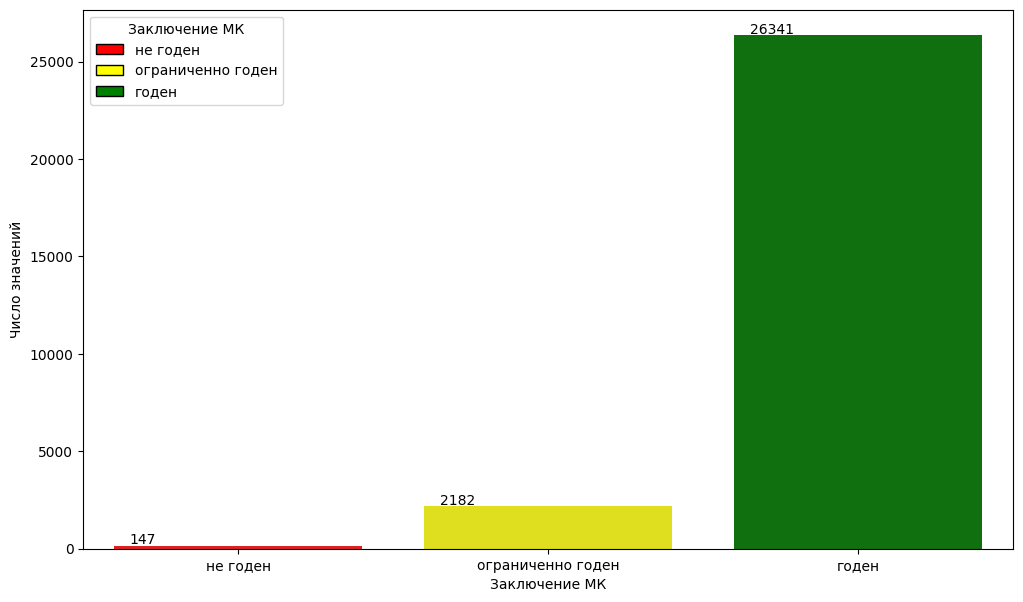

In [19]:
# Графически представляем данные до балансировки
drawConclusion012()

**Датафрейм сильно разбаланситрован.**

Удаляю 'лишние' строки категории 'годен' с пустым значением описания диагноза.

In [20]:
# Признаком для удаления является 2 == кЗаключениеМК и '' == ДиагнозОписание.
col_inx = df1.columns.get_loc('кЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()
#~ ДиагнозОписание
col_inx = df1.columns.get_loc('ДиагнозОписание')
col_lst2 = df1.iloc[:, col_inx].tolist()
for i in range(len(col_lst)):
  if 2 == col_lst[i]:
    i_elem = col_lst2[i]
    if (i_elem == i_elem):
      if not i_elem:
        col_lst2[i] = 'DIAGNOSIS_NAN'

print(f'размеры датафрейма df1 до удаления: {df1.shape}')
df1 = df1.assign(ДиагнозОписание=col_lst2)
df1 = df1.drop(df1[(df1['ДиагнозОписание'] == 'DIAGNOSIS_NAN')].index)
print(f'размеры датафрейма df1 после удаления: {df1.shape}')

размеры датафрейма df1 до удаления: (28670, 27)
размеры датафрейма df1 после удаления: (14691, 27)


0: не годен: 147
1: ограниченно годен: 2182
2: годен: 12362
--------------------------------------------------
общее число значений: 14691


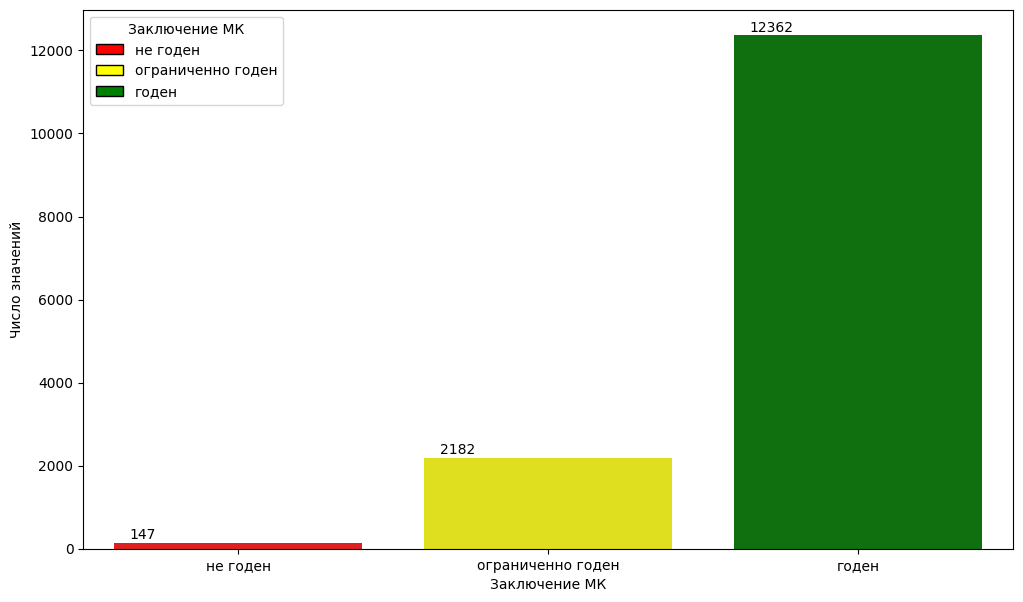

In [21]:
drawConclusion012()

Пронализировал колонки с пустыми значениями:

In [22]:
# # КлиентДатаРождения
# # КлиентПол
# # ДатаЗавершенияМедосмотра
# # ТипМедосмотра
# # ПсихОсвидетельствование
#  # Цех
# # Профессия
#  # ВредныеФакторы
# # ДиагнозМКБ
# nan_lst = df1[df1['ДиагнозМКБ'].isnull()].index
# u_lst = df1['ДиагнозМКБ'].unique().tolist()
# print('ДиагнозМКБ: ')
# print(f'  число строк с пустыми значениями: {len(nan_lst)}')
# print(f'  уникальные значения: {len(u_lst)}: {u_lst}')

Аналогично пустным данным по описанию диагноза рассматриваю 'ВредныеФакторы' для удаления записей с заключением 'годен':

In [23]:
col_inx = df1.columns.get_loc('кЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()
#~ ВредныеФакторы - Harmful Factors
col_inx = df1.columns.get_loc('ВредныеФакторы')
col_lst2 = df1.iloc[:, col_inx].tolist()
hf_count2 = 0
for i in range(len(col_lst)):
  if 2 == col_lst[i]:
    i_elem = col_lst2[i]
    if (i_elem == i_elem):
      if not i_elem:
        hf_count2 += 1

print(f'число строк с пустыми значениями в колонке "ВредныеФакторы" для записей "годен": {hf_count2}')

del col_inx
del col_lst
del col_lst2

число строк с пустыми значениями в колонке "ВредныеФакторы" для записей "годен": 0


Пустых данных в колонке 'ВредныеФакторы' с заключением 'годен' нет, поэтому строки не удаляю.

In [24]:
# Перенумерация строк
df1.reset_index(drop=True, inplace=True)
print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (14691, 27)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккДиагнозМКБ,ккЦехПрофессия
14688,1219937f-a0e8-11ec-80ff-0cc47aab8067,4f51d3f3-26aa-11e8-80c9-0cc47aab8067,1985-05-14T00:00:00,Женский,Женский,2022-03-11T00:00:00,Периодический,Периодический,False,e2d97574-7ada-11e9-80cf-0cc47aab8067,...,,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14689,5b0169c6-f691-11ec-8102-0cc47aab8067,b2129e9a-f2af-11ec-8102-0cc47aab8067,1964-09-27T00:00:00,Мужской,Мужской,2022-06-28T00:00:00,Периодический,Периодический,True,992c8208-4e0d-11ed-8107-0cc47aab8067,...,,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14690,ef2f77c3-5fef-11ed-8109-0cc47aab8067,dd09abd8-d4f1-11e7-80de-708bcd7f83cd,1959-08-18T00:00:00,Мужской,Мужской,2022-11-09T00:00:00,Периодический,Периодический,False,b7d3ed16-d4f1-11e7-80de-708bcd7f83cd,...,,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Искусственно добавляем минорные классы: 0 - не годен, 1 - ограниченно годен.**

In [25]:
# Искусственно добавляем классы: 0 - не годен, 1 - ограниченно годен
col_inx = df1.columns.get_loc('кЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'кЗаключениеМК: {len(col_lst)}: {col_lst}')

# 0 - не годен, 1 - ограниченно годен, 2 - годен
lst0 = list()
lst1 = list()
lst2 = list()
for i in range(df1.shape[0]):
  if 0 == col_lst[i]:
    lst0.append(i)
  elif 1 == col_lst[i]:
    lst1.append(i)
  elif 2 == col_lst[i]:
    lst2.append(i)

print(f'0 - не годен: {len(lst0)}')
print(f'1 - ограниченно годен: {len(lst1)}')
print(f'2 - годен: {len(lst2)}')
print(f'0+1+2: {len(lst0)+len(lst1)+len(lst2)}')

0 - не годен: 147
1 - ограниченно годен: 2182
2 - годен: 12362
0+1+2: 14691


In [26]:
# создаем копию нужных строк и добавляем их в отдельный df
adf0 = df1.loc[lst0].copy()
adf1 = df1.loc[lst1].copy()
print(f'размеры датафрейма adf0: {adf0.shape}, len(lst0): {len(lst0)}')
print(f'размеры датафрейма adf1: {adf1.shape}, len(lst1): {len(lst1)}')
print(f'размеры датафрейма df1: {df1.shape}')

# добавляем новый adf0, adf1 в исходный df1
#~~~
# for j in range(80):
#   df1 = pd.concat([df1, adf0], ignore_index=True)
# for j in range(4):
#   df1 = pd.concat([df1, adf1], ignore_index=True)
#~~~
for j in range(20):
  df1 = pd.concat([df1, adf0], ignore_index=True)
for j in range(1):
  df1 = pd.concat([df1, adf1], ignore_index=True)
#~~~

print('='*50)
print(f'размеры датафрейма df1: {df1.shape}')

размеры датафрейма adf0: (147, 27), len(lst0): 147
размеры датафрейма adf1: (2182, 27), len(lst1): 2182
размеры датафрейма df1: (14691, 27)
размеры датафрейма df1: (19813, 27)


0: не годен: 3087
1: ограниченно годен: 4364
2: годен: 12362
--------------------------------------------------
общее число значений: 19813


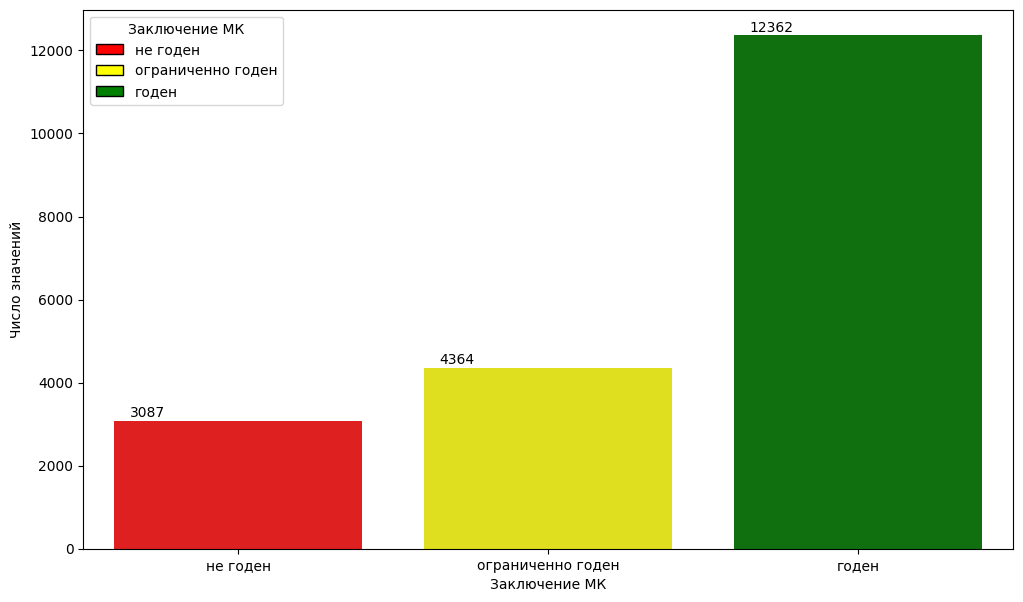

In [27]:
drawConclusion012()

Датасет стал более сбалансированным. Перемешиваем все строки после добавления.

In [28]:
print(f'размеры датафрейма df1: {df1.shape}')
df1.tail(3)

размеры датафрейма df1: (19813, 27)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккДиагнозМКБ,ккЦехПрофессия
19810,1219937f-a0e8-11ec-80ff-0cc47aab8067,4f51d3f3-26aa-11e8-80c9-0cc47aab8067,1985-05-14T00:00:00,Женский,Женский,2022-03-11T00:00:00,Периодический,Периодический,False,e2d97574-7ada-11e9-80cf-0cc47aab8067,...,,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19811,5b0169c6-f691-11ec-8102-0cc47aab8067,b2129e9a-f2af-11ec-8102-0cc47aab8067,1964-09-27T00:00:00,Мужской,Мужской,2022-06-28T00:00:00,Периодический,Периодический,True,992c8208-4e0d-11ed-8107-0cc47aab8067,...,,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19812,ef2f77c3-5fef-11ed-8109-0cc47aab8067,dd09abd8-d4f1-11e7-80de-708bcd7f83cd,1959-08-18T00:00:00,Мужской,Мужской,2022-11-09T00:00:00,Периодический,Периодический,False,b7d3ed16-d4f1-11e7-80de-708bcd7f83cd,...,,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
#~Перемешиваем строки в нашей таблице
for i in range(5):
  df1 = df1.sample(frac=1).reset_index(drop=True)
  print(f'перемешивание: {i}')

print('='*50)
print(f'размеры датафрейма df1: {df1.shape}')
df1.tail(3)

перемешивание: 0
перемешивание: 1
перемешивание: 2
перемешивание: 3
перемешивание: 4
размеры датафрейма df1: (19813, 27)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккДиагнозМКБ,ккЦехПрофессия
19810,a62f9db2-c480-11ed-8115-0cc47aab8067,46b04d0b-b68b-11ed-8113-0cc47aab8067,1986-11-25T00:00:00,Мужской,Мужской,2023-03-17T00:00:00,Периодический,Периодический,False,33259f51-b11b-11ed-8111-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр|[H52.0] Гипер...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19811,a5a350f7-6a33-11ed-8109-0cc47aab8067,2358bdac-013b-11ed-8103-0cc47aab8067,1969-06-25T00:00:00,Мужской,Мужской,2022-11-22T00:00:00,Периодический,Периодический,True,35a31340-fe89-11ec-8103-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр_x000D_|[H52.0...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19812,ae6c023b-7213-11ed-810a-0cc47aab8067,1d50feca-013b-11ed-8103-0cc47aab8067,1988-06-03T00:00:00,Мужской,Мужской,2022-12-02T00:00:00,Периодический,Периодический,True,35a31340-fe89-11ec-8103-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр|[H52.2] Астиг...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Добавление к датасету категориальных колонок

## ЗаключениеМК

In [30]:
print('ЗаключениеМК')
nan_lst = df1[df1['ЗаключениеМК'].isnull()].index
print(f'  число строк с пустыми значениями: {len(nan_lst)}')

ЗаключениеМК
  число строк с пустыми значениями: 0


In [31]:
col_inx = df1.columns.get_loc('кЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'кЗаключениеМК: {len(col_lst)}: {col_lst}')
# print(f'df1 число строк: {df1.shape[0]}')
# print(f'df1 число колонок: {df1.shape[1]}')

i_arr = np.zeros(df1.shape[0], dtype=int)
for i in range(df1.shape[0]):
  i_arr[i] = col_lst[i]

# Преобразование массива в формат one_hot_encoding (3-класса)
i_arr2 = utils.to_categorical(i_arr, 3)
ohe_lst2 = i_arr2.astype(int).tolist()
df1 = df1.assign(ккЗаключениеМК=ohe_lst2)
del i_arr2
del ohe_lst2

print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (19813, 27)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккДиагнозМКБ,ккЦехПрофессия
19810,a62f9db2-c480-11ed-8115-0cc47aab8067,46b04d0b-b68b-11ed-8113-0cc47aab8067,1986-11-25T00:00:00,Мужской,Мужской,2023-03-17T00:00:00,Периодический,Периодический,False,33259f51-b11b-11ed-8111-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр|[H52.0] Гипер...,2,"[0, 0, 1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
19811,a5a350f7-6a33-11ed-8109-0cc47aab8067,2358bdac-013b-11ed-8103-0cc47aab8067,1969-06-25T00:00:00,Мужской,Мужской,2022-11-22T00:00:00,Периодический,Периодический,True,35a31340-fe89-11ec-8103-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр_x000D_|[H52.0...,1,"[0, 1, 0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
19812,ae6c023b-7213-11ed-810a-0cc47aab8067,1d50feca-013b-11ed-8103-0cc47aab8067,1988-06-03T00:00:00,Мужской,Мужской,2022-12-02T00:00:00,Периодический,Периодический,True,35a31340-fe89-11ec-8103-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр|[H52.2] Астиг...,2,"[0, 0, 1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Возраст

In [32]:
print('Возраст')
print('  КлиентДатаРождения')
nan_lst = df1[df1['КлиентДатаРождения'].isnull()].index
print(f'    число строк с пустыми значениями: {len(nan_lst)}')
print('  ДатаЗавершенияМедосмотра')
nan_lst = df1[df1['ДатаЗавершенияМедосмотра'].isnull()].index
print(f'    число строк с пустыми значениями: {len(nan_lst)}')

Возраст
  КлиентДатаРождения
    число строк с пустыми значениями: 0
  ДатаЗавершенияМедосмотра
    число строк с пустыми значениями: 0


In [33]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода Возраст клиента
#~~~~~~~~~~~~~~~~~~~~~~~~
# Возраст клиента = ДатаЗавершенияМедосмотра - КлиентДатаРождения
#~~~~~~~~~~~~~~~~~~~~~~~~
def getAgeCategory(ageN, ageClassCount):
  '''
    Возраст превращаем в категориальный: до 18лет, далее через 5, всего 11 классов
    вход:
        ageN: возраст в годах
        ageClassCount: число классов
    выход:
        retVal: индекс категории: 0-17: 0, 18-22: 1, 23-27: 2, ...., 73..: 10
  '''
  #age2 = int((arg-13)/5)
  age2 = (ageN-13)/5
  retVal = max(0, min((ageClassCount-1),age2))
  return retVal

In [34]:
# КлиентДатаРождения
col_inx = df1.columns.get_loc('КлиентДатаРождения')
col_lst = df1.iloc[:, col_inx].tolist()
datetime_lst1 = []
for time_stamp in col_lst:
  datetime_obj = datetime.strptime(time_stamp, '%Y-%m-%dT%H:%M:%S')
  datetime_lst1.append(datetime_obj)

# ДатаЗавершенияМедосмотра
col_inx = df1.columns.get_loc('ДатаЗавершенияМедосмотра')
col_lst = df1.iloc[:, col_inx].tolist()
datetime_lst2 = []
for time_stamp in col_lst:
  datetime_obj = datetime.strptime(time_stamp, '%Y-%m-%dT%H:%M:%S')
  datetime_lst2.append(datetime_obj)

# рассчитываю возраст клиента
i_arr1 = np.zeros(df1.shape[0], dtype=int)
for i in range(df1.shape[0]):
  delta_dates21 = datetime_lst2[i].date() - datetime_lst1[i].date()
  delta_days21 = delta_dates21.days
  delta_years21 = delta_days21 // 365
  i_arr[i] = delta_years21
  i_arr1[i] = getAgeCategory(delta_years21, 11)

# Заполняем колонку 'кВозраст' значениями из массива i_arr
df1 = df1.assign(кВозраст=i_arr)

# Преобразование массива в формат one_hot_encoding (11-классов)
i_arr2 = utils.to_categorical(i_arr1, 11)
ohe_lst2 = i_arr2.astype(int).tolist()
df1 = df1.assign(ккВозраст=ohe_lst2)

del i_arr1
del i_arr2
del ohe_lst2
del datetime_lst1
del datetime_lst2

print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (19813, 27)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккДиагнозМКБ,ккЦехПрофессия
19810,a62f9db2-c480-11ed-8115-0cc47aab8067,46b04d0b-b68b-11ed-8113-0cc47aab8067,1986-11-25T00:00:00,Мужской,Мужской,2023-03-17T00:00:00,Периодический,Периодический,False,33259f51-b11b-11ed-8111-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр|[H52.0] Гипер...,2,"[0, 0, 1]",36,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",NaN,NaN,NaN,NaN,NaN
19811,a5a350f7-6a33-11ed-8109-0cc47aab8067,2358bdac-013b-11ed-8103-0cc47aab8067,1969-06-25T00:00:00,Мужской,Мужской,2022-11-22T00:00:00,Периодический,Периодический,True,35a31340-fe89-11ec-8103-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр_x000D_|[H52.0...,1,"[0, 1, 0]",53,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",NaN,NaN,NaN,NaN,NaN
19812,ae6c023b-7213-11ed-810a-0cc47aab8067,1d50feca-013b-11ed-8103-0cc47aab8067,1988-06-03T00:00:00,Мужской,Мужской,2022-12-02T00:00:00,Периодический,Периодический,True,35a31340-fe89-11ec-8103-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр|[H52.2] Астиг...,2,"[0, 0, 1]",34,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",NaN,NaN,NaN,NaN,NaN


## КлиентПол

In [35]:
print('КлиентПол')
nan_lst = df1[df1['КлиентПол'].isnull()].index
print(f'  число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['КлиентПол'].unique().tolist()
print(f'  уникальные значения: {len(u_lst)}: {u_lst}')

КлиентПол
  число строк с пустыми значениями: 0
  уникальные значения: 2: ['Мужской', 'Женский']


In [36]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'КлиентПол'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getGenderCategory(arg):
  '''
    Бинарный пол клиента
    вход:
        arg: ['Женский', 'Мужской']
    выход:
        retVal: 0 - Женский, 1 - Мужской
  '''
  if 'Женский' == arg:
    retVal = 0
  else:
    retVal = 1
  return retVal

In [37]:
col_inx = df1.columns.get_loc('КлиентПол')
col_lst = df1.iloc[:, col_inx].tolist()

for i in range(df1.shape[0]):
  i_arr[i] = getGenderCategory(col_lst[i])

df1 = df1.assign(кКлиентПол=i_arr)

print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (19813, 27)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккДиагнозМКБ,ккЦехПрофессия
19810,a62f9db2-c480-11ed-8115-0cc47aab8067,46b04d0b-b68b-11ed-8113-0cc47aab8067,1986-11-25T00:00:00,Мужской,Мужской,2023-03-17T00:00:00,Периодический,Периодический,False,33259f51-b11b-11ed-8111-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр|[H52.0] Гипер...,2,"[0, 0, 1]",36,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,NaN,NaN,NaN,NaN
19811,a5a350f7-6a33-11ed-8109-0cc47aab8067,2358bdac-013b-11ed-8103-0cc47aab8067,1969-06-25T00:00:00,Мужской,Мужской,2022-11-22T00:00:00,Периодический,Периодический,True,35a31340-fe89-11ec-8103-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр_x000D_|[H52.0...,1,"[0, 1, 0]",53,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,NaN,NaN,NaN,NaN
19812,ae6c023b-7213-11ed-810a-0cc47aab8067,1d50feca-013b-11ed-8103-0cc47aab8067,1988-06-03T00:00:00,Мужской,Мужской,2022-12-02T00:00:00,Периодический,Периодический,True,35a31340-fe89-11ec-8103-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр|[H52.2] Астиг...,2,"[0, 0, 1]",34,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,NaN,NaN,NaN,NaN


## ПсихОсвидетельствование

In [38]:
print('ПсихОсвидетельствование')
nan_lst = df1[df1['ПсихОсвидетельствование'].isnull()].index
print(f'  число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ПсихОсвидетельствование'].unique().tolist()
print(f'  уникальные значения: {len(u_lst)}: {u_lst}')

ПсихОсвидетельствование
  число строк с пустыми значениями: 0
  уникальные значения: 2: [False, True]


In [39]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'ПсихОсвидетельствование'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getPsychicExaminationCategory(arg):
  '''
    Бинарный Тип ПсихОсвидетельствование
    вход:
        arg: [False, True]
    выход:
        retVal: 0 - False, 1 - True
  '''
  if False == arg:
    retVal = 0
  else:
    retVal = 1
  return retVal

In [40]:
col_inx = df1.columns.get_loc('ПсихОсвидетельствование')
col_lst = df1.iloc[:, col_inx].tolist()

for i in range(df1.shape[0]):
  i_arr[i] = getPsychicExaminationCategory(col_lst[i])

df1 = df1.assign(кПсихОсвидетельствование=i_arr)

print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (19813, 27)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккДиагнозМКБ,ккЦехПрофессия
19810,a62f9db2-c480-11ed-8115-0cc47aab8067,46b04d0b-b68b-11ed-8113-0cc47aab8067,1986-11-25T00:00:00,Мужской,Мужской,2023-03-17T00:00:00,Периодический,Периодический,False,33259f51-b11b-11ed-8111-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр|[H52.0] Гипер...,2,"[0, 0, 1]",36,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,NaN,NaN,NaN
19811,a5a350f7-6a33-11ed-8109-0cc47aab8067,2358bdac-013b-11ed-8103-0cc47aab8067,1969-06-25T00:00:00,Мужской,Мужской,2022-11-22T00:00:00,Периодический,Периодический,True,35a31340-fe89-11ec-8103-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр_x000D_|[H52.0...,1,"[0, 1, 0]",53,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,1,NaN,NaN,NaN
19812,ae6c023b-7213-11ed-810a-0cc47aab8067,1d50feca-013b-11ed-8103-0cc47aab8067,1988-06-03T00:00:00,Мужской,Мужской,2022-12-02T00:00:00,Периодический,Периодический,True,35a31340-fe89-11ec-8103-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр|[H52.2] Астиг...,2,"[0, 0, 1]",34,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,1,NaN,NaN,NaN


## ВредныеФакторы

In [41]:
print('ВредныеФакторы')
nan_lst = df1[df1['ВредныеФакторы'].isnull()].index
print(f'  число строк с пустыми значениями: {len(nan_lst)}')

ВредныеФакторы
  число строк с пустыми значениями: 59


In [42]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки по запятым
#~~~~~~~~~~~~~~~~~~~~~~~~
def comma_string_split(arg):
  '''
    Расщепление строки по запятым, удаление пробелов перед словом и после
    вход:
        arg: строка с запятыми или без запятых
    выход:
        retVal: список строк, разделенных запятыми,
        если строк пустая или nan, то вернется пустой список,
        если строка не содержит запятые, то вернется список, состоящий из одного элемента
  '''
  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # приводим к нижнему регистру, удаляем пробелы в начале и конце слова
      #str1 = arg.lower().strip()
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          retVal.append(str_item2)

  return retVal

In [43]:
# Формируем столбец-список значений вредных факторов, заменяем nan - пустыми строками,
# убираем пробелы перед и после значений
col_inx = df1.columns.get_loc('ВредныеФакторы')
col_lst = df1.iloc[:, col_inx].tolist()

# Harmful Factors
hf_lst = [''] * df1.shape[0]

for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым, убирая пробелы у каждого элемента и слева и справа
      elem_lst = comma_string_split(i_elem)
      hf_lst[i] = ",".join(elem_lst)

print(f'hf_lst: {len(hf_lst)}: {hf_lst}')

hf_lst: 19813: ['6.1,9,15', '23', '1.29.2,4.1,4.3.2,11.1,11.4,17,18.2', '18.1,22', '5.1', '4.2.5,4.7,5.1,6.1,9,18.1', '5.1,6.2,11.1', '18.1,22', '18.1,23', '4.2.5,23', '4.4,18.1,4.4,18.1', '5.1,6.2,11.1,11.3,11.4', '26', '4.2.2,4.2.5,11.1', '1.17,4.2.1,4.7,5.1,6,23,1.17,4.2.1,4.7,5.1,6,23', '25', '4.3.2,4.4,5.1,6.2,11.1,11.4', '23', '6.1,9', '1.14.2,1.37.1,1.50,4.4', '25', '4.2.5,6.1,9', '4.4,6.1', '4.7,5.1,6.1,11.1,12,13,15', '1.29.2,4.1', '6', '4.1,6.2,18.1,18.2,4.1,6.2,18.1,18.2', '18.2', '4.3.2,5.1,6.1,4.3.2,5.1,6.1', '9', '4.2.5', '25', '04.02.2005', '3.1.7,5.1,6.1,11.1', '4.2.5,4.4,12,13,6.1', '4.4,5.1,6.2,11.1,11.4', '4.2.5,23', '4.7,5.1,6.1,11.1,12,13,15', '1.29.2,4.1,4.3.2,5.1,11.1,11.3,17,18.2', '5.1,23', '4.8,23', '23', '23', '4.7,5.1,6.1,11.1,13', '1.29.2,4.1,4.3.2,17,18.2', '4.2.5', '18.1,22', '4.2.5', '4.7,5.1,6,9', '4.4,4.7,4.8,5.1,6,12,17', '15,23', '18.2,18.1,1.1,1.39,1.50,4.3.2,5.1,11.1,11.3,11.4', '4.4,4.5,6.1', '3.1.2,4.3.1,6,6.1,6.2,11,11.4,3.1.2,4.3.1,6,6.1,6.2,11

In [44]:
# Формируем список уникальных значений вредных факторов
# Harmful Factors
u_hf_lst = list()

for i in range(len(hf_lst)):
  i_elem = hf_lst[i]
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          if len(u_hf_lst) > 0:
            # проверяем, что этого элемента нет в списке
            if not (elem1_lst in u_hf_lst):
              u_hf_lst.append(elem1_lst)
          else:
            u_hf_lst.append(elem1_lst)

print(f'u_hf_lst: {len(u_hf_lst)}: {u_hf_lst}')

u_hf_lst: 162: ['6.1', '9', '15', '23', '1.29.2', '4.1', '4.3.2', '11.1', '11.4', '17', '18.2', '18.1', '22', '5.1', '4.2.5', '4.7', '6.2', '4.4', '11.3', '26', '4.2.2', '1.17', '4.2.1', '6', '25', '1.14.2', '1.37.1', '1.50', '12', '13', '04.02.2005', '3.1.7', '4.8', '1.1', '1.39', '4.5', '3.1.2', '4.3.1', '11', '1.15', '8', '4.9', '27', '3.1.1', '4.2.3', '4.2.4', '2.4', '4.3', '4.6', '1.30.1', '1.8.1.2', '1.48', '10', '3.4', '1.5', '1.37.2', '3.1', '5.2.1', '18', '18.фев', '4.2', '1.23', '3.1.9.3', '1.34.1', '18.янв', '1.3', '1.29.4', '1.36.1', '1.8.1.1', '1.8.2.1', '1.8.2.2', '1.8.3.1', '1.8.3.2', '5.2', '3.1.8', '1.2', '1.51.1', '1.51.2', '2.4.1', '2.4.2', '2.4.3', '2.4.4', '2.4.5', '4.10', '1.27.1', '1.5.1', '1.19.1', '04.03.2001', '05.янв', '3.3', '1.18.3', '1.29.1', '1.53.1', '1.53.2', '1.24', '1.45.1', '1.49.14', '3.1.3', '5.2.2', '24', '11.янв', '16', '3.1.8.2', '1.36', '1.8.1', '1.29.3', '1.37.1.1', '3.1.8.3', '1.52.5', '1.20', '1.44', 'янв.48', '11.мар', '14', '1.38', '06.фев

Оценим число повторений ВредныхФакторов, будем использовать в нейросети только наиболее часто встречающиеся значения, остальные, которые встречаются редко обозначим - "все остальные". Создаем словарь ВредныеФакторы: ключи - названия вредных факторов, значения - число повторений.


In [45]:
u_hf_dict = {}
for i_elem in u_hf_lst:
  u_hf_dict[i_elem] = 0

# пробегаемся по всем строкам колонки и заполняем словарь
for i in range(len(hf_lst)):
  i_elem = hf_lst[i]
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          u_hf_dict[elem1_lst] += 1

# сортируем словарь по убыванию
u_hf_sort_dict = dict(sorted(u_hf_dict.items(), key=lambda x: x[1], reverse=True))
print(f'u_hf_sort_dict: {len(u_hf_sort_dict)}: {u_hf_sort_dict}')

del u_hf_dict

u_hf_sort_dict: 162: {'5.1': 5872, '4.4': 4677, '11.1': 4319, '23': 3892, '6.1': 3849, '4.2.5': 3799, '6.2': 2776, '18.1': 2714, '9': 2424, '11.4': 2403, '4.7': 2280, '15': 2196, '6': 2102, '17': 1625, '1.50': 1592, '18.2': 1449, '4.3.2': 1299, '4.3.1': 1171, '4.8': 1096, '25': 1043, '13': 905, '27': 816, '1.1': 760, '4.1': 727, '3.1.7': 674, '11.3': 670, '12': 634, '11': 593, '1.39': 591, '1.29.2': 562, '26': 430, '1.30.1': 414, '3.1.2': 409, '18': 363, '4.2.1': 351, '1.37.1': 336, '1.14.2': 326, '1.23': 304, '5.2': 296, '5.2.1': 293, '3.1': 276, '4.9': 243, '1.3': 237, '1.5': 231, '8': 226, '1.37.2': 226, '1.36.1': 225, '22': 215, '4.2.3': 194, '1.15': 179, '1.34.1': 173, '04.02.2005': 172, '3.4': 167, '1.8.1.1': 156, '4.3': 153, '2.4.2': 145, '4.2.2': 131, '4.2.4': 128, '4.6': 128, '4.5': 123, '4.10': 111, '3.1.9.3': 108, '1.17': 97, '1.48': 95, '1.29.1': 89, '4.2': 87, '24': 86, '1.2': 84, '1.27.1': 84, '1.36': 82, '1.8.1.2': 79, '1.19.1': 75, '3.1.8': 68, '3.1.1': 67, '18.янв': 65

In [46]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Графическое представление количества признаков в виде гистограммы
#~~~~~~~~~~~~~~~~~~~~~~~~
def drawBarCountFactors(factor_dict, factor_name):
  '''
    Графическое представление количества признаков
    вход:
        factor_dict: словарь, где ключ это название признака, а значение - это число признаков
        factor_name: вербальное описание признака
  '''
  plt.figure(figsize=(20, 5))
  plt.bar(factor_dict.keys(), factor_dict.values(), color='blue')
  plt.xticks(rotation=90)
  plt.xlabel(factor_name)
  plt.ylabel('Общее число повторений')
  plt.gca().set_facecolor('white')
  plt.show()

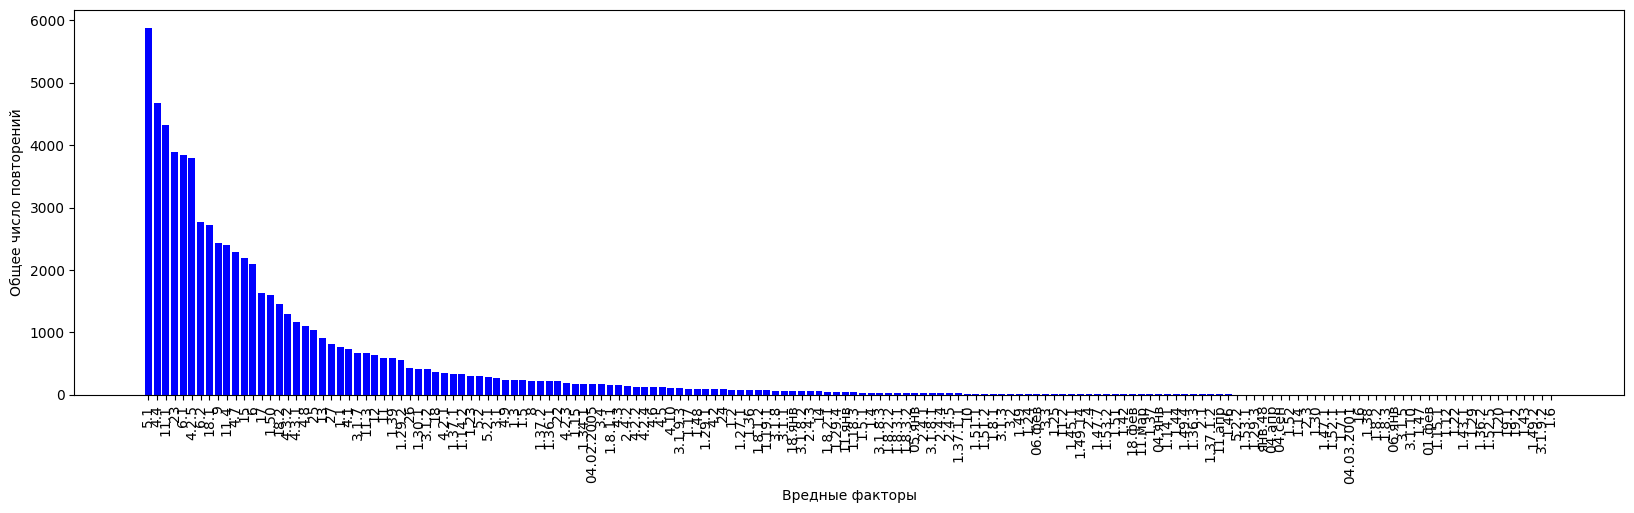

In [47]:
# Отобразим на гистограмме (столбчатой диаграмме) - частоту использования наших признаков - вредных факторов
drawBarCountFactors(u_hf_sort_dict, 'Вредные факторы')

**Из графика видно, что основное влияние оказывают начальные признаки, остальные - незначительное, поэтому оставим только первые 50 признаков. Также вводя ограничение по количеству признаков, мы убираем влияние на обучение нейронной сети ошибочных вредных факторов: '04.02.2005', '11.янв', '01.фев', '18.янв', '04.янв', '05.янв', '06.фев', '04.апр', '11.мар', '11.апр', '18.фев', 'янв.48', '04.сен', '06.янв', '04.03.2001'.**

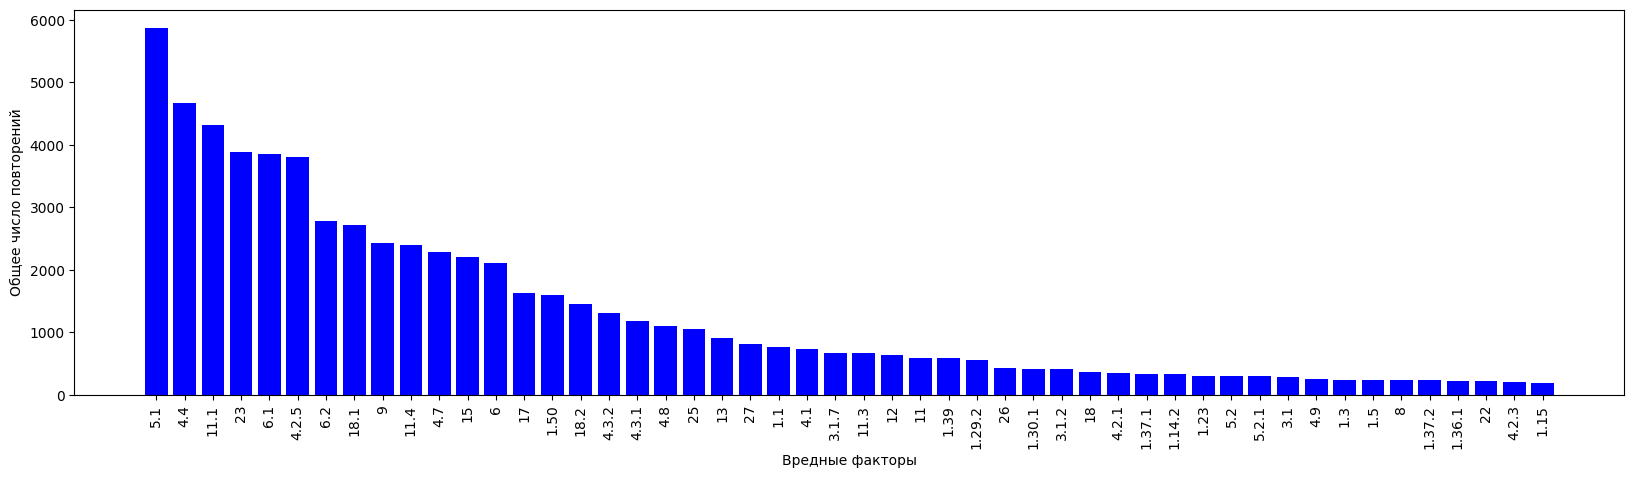


hf_dict_keys: 112: ['1.34.1', '04.02.2005', '3.4', '1.8.1.1', '4.3', '2.4.2', '4.2.2', '4.2.4', '4.6', '4.5', '4.10', '3.1.9.3', '1.17', '1.48', '1.29.1', '4.2', '24', '1.2', '1.27.1', '1.36', '1.8.1.2', '1.19.1', '3.1.8', '3.1.1', '18.янв', '3.1.8.2', '2.4.3', '14', '1.8.2.1', '1.29.4', '11.янв', '1.18.3', '1.5.1', '1.4', '3.1.8.3', '1.8.2.2', '1.8.3.1', '1.8.3.2', '05.янв', '2.4.1', '3.1.8.1', '2.4.4', '2.4.5', '1.37.1.1', '10', '1.51.1', '1.51.2', '1.8.1', '3.1.3', '3.2', '1.49', '1.24', '06.фев', '3.3', '1.25', '11.2', '1.45.1', '1.49.14', '2.4', '1.47.7', '1.53.2', '1.51', '1.42', '18.фев', '11.мар', '1.37', '04.янв', '1.14.1', '1.44', '1.49.4', '1.36.3', '2.1', '1.37.1.2', '11.апр', '1.46', '5.2.2', '1.53.1', '1.29.3', 'янв.48', '04.апр', '04.сен', '1.52', '1.14', '2.3', '1.30', '1.47.1', '1.52.1', '1.7.1', '04.03.2001', '16', '1.38', '1.8.2', '1.8.3', '06.янв', '3.1.5', '3.1.10', '1.47', '01.фев', '1.15.1', '1.12', '1.22', '1.43.1', '1.29', '1.36.2', '1.52.5', '1.20', '19.1', '

In [48]:
hf_dict_key = list(u_hf_sort_dict.keys())[50:]
for hf_key in hf_dict_key:
  del u_hf_sort_dict[hf_key]

drawBarCountFactors(u_hf_sort_dict, 'Вредные факторы')
print()
print(f'hf_dict_keys: {len(hf_dict_key)}: {hf_dict_key}')
print(f'u_hf_sort_dict: {len(u_hf_sort_dict)}: {u_hf_sort_dict}')

del hf_dict_key

**В новом огранниченном списке ошибочные вредные факторы отсутствуют. Все вредные факторы, которые не попадают в выделенный диапазон 50-ти значений обозначаем как 'все остальные'.**

In [49]:
u_hf_lst.clear()
u_hf_lst = list(u_hf_sort_dict.keys())
print()
print(f'{len(u_hf_lst)}: u_hf_lst: {u_hf_lst}')

del u_hf_sort_dict


50: u_hf_lst: ['5.1', '4.4', '11.1', '23', '6.1', '4.2.5', '6.2', '18.1', '9', '11.4', '4.7', '15', '6', '17', '1.50', '18.2', '4.3.2', '4.3.1', '4.8', '25', '13', '27', '1.1', '4.1', '3.1.7', '11.3', '12', '11', '1.39', '1.29.2', '26', '1.30.1', '3.1.2', '18', '4.2.1', '1.37.1', '1.14.2', '1.23', '5.2', '5.2.1', '3.1', '4.9', '1.3', '1.5', '8', '1.37.2', '1.36.1', '22', '4.2.3', '1.15']


In [50]:
#~~~~~~~~~~~~~~~~~~~~~~~~
#multi_hot_encoding
hf_mhe_lst = list()

# число классов
harmful_factors_class_count = len(u_hf_lst) + 1
# то есть по умолчанию выбираем индекс вредного фактора, которого нет в списке
# наших выбранных и ограниченных уникальных вредных факторов: вредный фактор=`все остальные`
nan_inx = len(u_hf_lst)

# пробегаемся по всем строкам колонки
for i in range(len(hf_lst)):
  i_elem = hf_lst[i]
  # устанавливаем все признаки в нули
  i_mhe_lst = [0] * harmful_factors_class_count
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          # проверяем, есть ли этот элемент в списке
          if elem1_lst in u_hf_lst:
            inx = u_hf_lst.index(elem1_lst)
            i_mhe_lst[inx] = 1
          else:
            i_mhe_lst[nan_inx] = 1
      else:
        i_mhe_lst[nan_inx] = 1
    else:
      i_mhe_lst[nan_inx] = 1
  else:
    i_mhe_lst[nan_inx] = 1
  #~~~
  hf_mhe_lst.append(i_mhe_lst)

df1 = df1.assign(ккВредныеФакторы=hf_mhe_lst)
del hf_lst
del u_hf_lst
del hf_mhe_lst

print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (19813, 27)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккДиагнозМКБ,ккЦехПрофессия
19810,a62f9db2-c480-11ed-8115-0cc47aab8067,46b04d0b-b68b-11ed-8113-0cc47aab8067,1986-11-25T00:00:00,Мужской,Мужской,2023-03-17T00:00:00,Периодический,Периодический,False,33259f51-b11b-11ed-8111-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр|[H52.0] Гипер...,2,"[0, 0, 1]",36,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",NaN,NaN
19811,a5a350f7-6a33-11ed-8109-0cc47aab8067,2358bdac-013b-11ed-8103-0cc47aab8067,1969-06-25T00:00:00,Мужской,Мужской,2022-11-22T00:00:00,Периодический,Периодический,True,35a31340-fe89-11ec-8103-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр_x000D_|[H52.0...,1,"[0, 1, 0]",53,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",NaN,NaN
19812,ae6c023b-7213-11ed-810a-0cc47aab8067,1d50feca-013b-11ed-8103-0cc47aab8067,1988-06-03T00:00:00,Мужской,Мужской,2022-12-02T00:00:00,Периодический,Периодический,True,35a31340-fe89-11ec-8103-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр|[H52.2] Астиг...,2,"[0, 0, 1]",34,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,1,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",NaN,NaN


## ДиагнозМКБ

In [51]:
print('ДиагнозМКБ')
nan_lst = df1[df1['ДиагнозМКБ'].isnull()].index
print(f'  число строк с пустыми значениями: {len(nan_lst)}')

ДиагнозМКБ
  число строк с пустыми значениями: 0


Формируем столбец-список значений ДиагнозМКБ, заменяем 'nan' пустыми строками (в данном датасете в этом нет необходимости, но оставляем эту процедуру, на случай если датасет будет изменен), убираем пробелы перед и после каждого значения.

In [52]:
col_inx = df1.columns.get_loc('ДиагнозМКБ')
col_lst = df1.iloc[:, col_inx].tolist()

# MKB
mkb_lst = [''] * df1.shape[0]

for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым, убирая пробелы у каждого элемента и слева и справа
      elem_lst = comma_string_split(i_elem)
      mkb_lst[i] = ",".join(elem_lst)

print(f'mkb_lst: {len(mkb_lst)}: {mkb_lst}')

mkb_lst: 19813: ['Z00.0', 'Z00.0', 'Z00.0,K29.3', 'Z00.0', 'Z00.0,F10.3', 'Z00.0', 'Z00.0,K29.5,H52.2', 'Z00.0,H52.1', 'Z00.0,I11.9', 'Z00.0,K03.66', 'Z00.0,H25,F06.8,F10.3,I11.9', 'Z00.0,K04.5', 'Z00.0', 'Z00.0,H52.1', 'Z00.0,K02.1', 'Z00.0,D25.9,I11.9', 'Z00.0', 'Z00.0,K02.1', 'Z00.0,H52.1', 'Z00.0,H52.1', 'Z00.0,D25', 'Z00.0', 'Z00.0,H52.0', 'Z00.0,K03.66,H91.1,I11.9', 'Z00.0,H52.2,G90.8', 'Z00.0', 'Z00.0,H50.9,I11.9', 'H52.4,Z00.0', 'Z00.0', 'Z00.0,H52.1', 'Z00.0,H52.1', 'N90.4,Z00.0,H52.0,I25.9,I11.9', 'Z00.0,H52.1', 'Z00.0,H52.1', 'Z00.0,H52.1,I11.9', 'Z00.0,H52.1,K02.0', 'Z00.0,H52.1,K02.1', 'Z00.0,K03.66,H91.1,I11.9', 'Z00.0', 'Z00.0,F70.0,F06.6', 'N95.2,Z00.0', 'Z00.0', 'Z00.0,K02.0', 'Z00.0,H52.1', 'Z00.0', 'Z00.0,H52.1', 'Z00.0', 'Z00.0', 'Z00.0,H52.0', 'Z00.0,K04.5,F06.9', 'Z00.0,K04.5,H52.1', 'Z00.0,T90.4', 'Z00.0,H52.1', 'Z00.0,K03.66', 'Z00.0,H52.1', 'Z00.0', 'Z00.0', 'Z00.0,I11.9', 'Z00.0,H52.1', 'Z00.0,H52.2,S68.2', 'Z00.0,H52.2', 'Z00.0,E14.9', 'Z00.0,F10.3,H25,F06.8'

In [53]:
# Формируем список уникальных значений вредных факторов
# MKB
u_mkb_lst = list()

for i in range(len(mkb_lst)):
  i_elem = mkb_lst[i]
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          if len(u_mkb_lst) > 0:
            # проверяем, что этого элемента нет в списке
            if not (elem1_lst in u_mkb_lst):
              u_mkb_lst.append(elem1_lst)
          else:
            u_mkb_lst.append(elem1_lst)

print(f'u_mkb_lst: {len(u_mkb_lst)}: {u_mkb_lst}')

u_mkb_lst: 351: ['Z00.0', 'K29.3', 'F10.3', 'K29.5', 'H52.2', 'H52.1', 'I11.9', 'K03.66', 'H25', 'F06.8', 'K04.5', 'K02.1', 'D25.9', 'D25', 'H52.0', 'H91.1', 'G90.8', 'H50.9', 'H52.4', 'N90.4', 'I25.9', 'K02.0', 'F70.0', 'F06.6', 'N95.2', 'F06.9', 'T90.4', 'S68.2', 'E14.9', 'F60.3', 'N70.9', 'K41.9', 'K25.3', 'K26.9', 'H74.8', 'K40.9', 'H74.1', 'K40.2', 'E11.8', 'K29.6', 'R25.1', 'I67.2', 'H11.1', 'H25.0', 'H40.1', 'K08.1', 'N95.1', 'H17.1', 'G40.9', 'N86', 'J38.0', 'F07.0', 'N84.1', 'G25.9', 'H50.1', 'B35.6', 'I10', 'J33.0', 'I83.9', 'M53.9', 'F10.1', 'I77.9', 'I72.1', 'K29.8', 'J00', 'K29.4', 'Z00.4', 'H90.3', 'K25.7', 'H40.9', 'F98.5', 'K26.3', 'H25.1', 'N60.2', 'E11.0', 'N83.2', 'H01.0', 'H47.2', 'L40.0', 'K05.3', 'N95.9', 'T95.8', 'K86.0', 'K29.7', 'G25.0', 'K05.2', 'J30.2', 'Q25.6', 'D27', 'A53.9', 'F10.2', 'H26.1', 'H26.9', 'R73.9', 'F06.7', 'N76.1', 'I48.2', 'I48.0', 'I25.2', 'I49.9', 'K81.9', 'H54.4', 'N81.2', 'H53.0', 'E14.8', 'K20', 'F95.0', 'K64.3', 'H27.9', 'H53.5', 'K82.8

По аналогии с вредными факторами, оценим число повторений диагнозов МКБ, будем использовать в нейросети только наиболее часто встречающиеся значения, остальные, которые встречаются редко обозначим - "все остальные". Создаем словарь ДиагнозМКБ: ключи - названия диагнозов МКБ, значения - число повторений. Также скорее всего исключим из обучения нейронной сети код '[Z00.0] Общий медицинский осмотр', так как он с очень высокой вероятностью встречается почти у каждого пациента и не несет на себе признаков различимости, необходимых для решения нашей задачи.

In [54]:
u_mkb_dict = {}
for i_elem in u_mkb_lst:
  u_mkb_dict[i_elem] = 0

# пробегаемся по всем строкам колонки и заполняем словарь
for i in range(len(mkb_lst)):
  i_elem = mkb_lst[i]
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          u_mkb_dict[elem1_lst] += 1

# сортируем словарь по убыванию
u_mkb_sort_dict = dict(sorted(u_mkb_dict.items(), key=lambda x: x[1], reverse=True))
print(f'u_mkb_sort_dict: {len(u_mkb_sort_dict)}: {u_mkb_sort_dict}')

del u_mkb_dict

u_mkb_sort_dict: 351: {'Z00.0': 19679, 'H52.1': 4430, 'I11.9': 2254, 'H52.0': 1483, 'H52.2': 1396, 'K02.1': 1181, 'K04.5': 761, 'K29.5': 443, 'K03.66': 378, 'K29.3': 349, 'N95.2': 318, 'F10.3': 246, 'N95.1': 236, 'D25': 214, 'F06.6': 173, 'K26.9': 157, 'N86': 156, 'H90.3': 154, 'F06.8': 148, 'K02.0': 145, 'D25.9': 143, 'H91.1': 137, 'H74.1': 129, 'J33.0': 97, 'R25.1': 87, 'K05.3': 87, 'H25': 86, 'F60.3': 83, 'E14.9': 78, 'N70.9': 70, 'B35.6': 69, 'T90.4': 67, 'R73.9': 67, 'F70.0': 66, 'G90.8': 58, 'K40.9': 58, 'N60.2': 58, 'H40.1': 54, 'N90.4': 52, 'H53.0': 52, 'I25.9': 50, 'H90.4': 50, 'M42.1': 50, 'K40.2': 49, 'I10': 48, 'L40.0': 47, 'N83.2': 46, 'H50.9': 45, 'H27.0': 45, 'K26.3': 44, 'N84.1': 42, 'I77.9': 42, 'I72.1': 42, 'K29.6': 40, 'N80.0': 40, 'I67.2': 38, 'K29.8': 37, 'N76.1': 36, 'H66.1': 35, 'K29.7': 32, 'Z32.1': 31, 'K26.7': 29, 'F06.9': 28, 'I83.9': 28, 'H40.9': 28, 'I49.9': 28, 'I25.8': 27, 'H11.0': 27, 'K08.1': 26, 'H25.0': 25, 'G25.9': 23, 'I49.8': 23, 'H52.4': 22, 'H11.

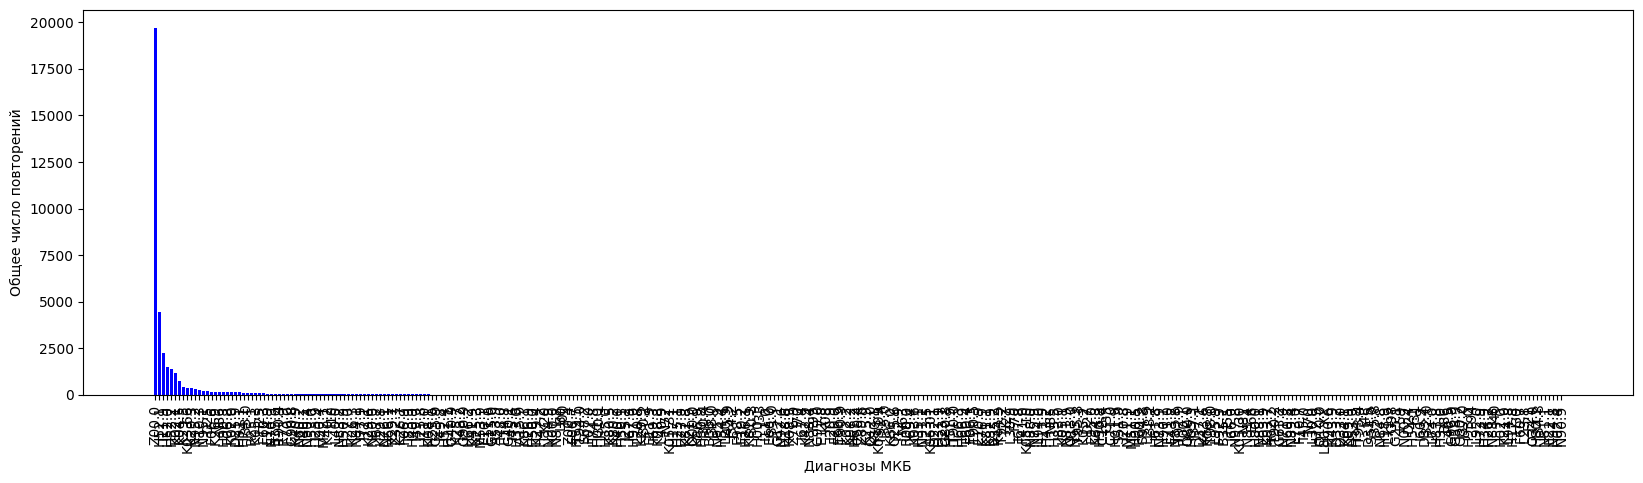

In [55]:
# Отобразим на гистограмме - частоту использования наших признаков - Диагнозов МКБ
drawBarCountFactors(u_mkb_sort_dict, 'Диагнозы МКБ')

**Из графика видно, что основное влияние оказывают начальные признаки, остальные - незначительное, поэтому оставим только первые 50 признаков.**

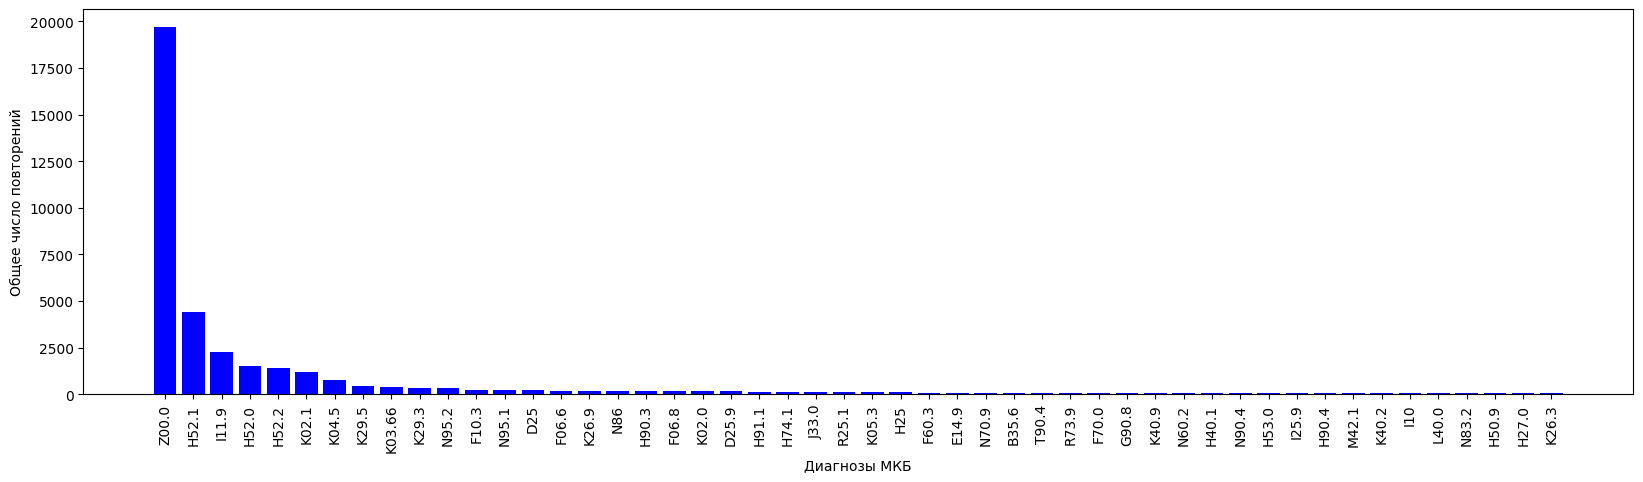


mkb_dict_keys: 301: ['N84.1', 'I77.9', 'I72.1', 'K29.6', 'N80.0', 'I67.2', 'K29.8', 'N76.1', 'H66.1', 'K29.7', 'Z32.1', 'K26.7', 'F06.9', 'I83.9', 'H40.9', 'I49.9', 'I25.8', 'H11.0', 'K08.1', 'H25.0', 'G25.9', 'I49.8', 'H52.4', 'H11.1', 'G40.9', 'K25.7', 'I48.2', 'G90.9', 'H66.2', 'K41.9', 'K25.3', 'M53.9', 'F10.1', 'E11.0', 'G25.0', 'A53.9', 'I48.0', 'E14.8', 'G40.1', 'I45.6', 'H33.0', 'A15.9', 'K86.1', 'H26.9', 'H50.0', 'K29.4', 'H47.2', 'K20', 'N94.9', 'K00.0', 'N81.2', 'L80', 'J00', 'Z00.4', 'F06.7', 'H53.5', 'T94.0', 'S68.2', 'F07.0', 'H74.8', 'H01.0', 'J30.1', 'H35.0', 'K80.5', 'K80.2', 'H40.0', 'H50.1', 'I25.2', 'I67.9', 'H91.9', 'L20.8', 'K29.9', 'J30.2', 'E11.9', 'I69.3', 'K08.8', 'L40.9', 'N72', 'K05.31', 'H17.1', 'H25.1', 'H27.9', 'K82.8', 'K21.9', 'O00.0', 'K86.9', 'H50.8', 'J30.4', 'B36.0', 'J38.0', 'N95.9', 'H54.4', 'L20.9', 'J45.9', 'J34.2', 'F98.5', 'F10.2', 'H26.1', 'K81.9', 'J30.3', 'H00.1', 'J33', 'I11.0', 'E66.0', 'J31.0', 'G12.1', 'N92.6', 'H18.6', 'K08.9', 'Z76.9

In [56]:
mkb_dict_key = list(u_mkb_sort_dict.keys())[50:]
for mkb_key in mkb_dict_key:
  del u_mkb_sort_dict[mkb_key]

drawBarCountFactors(u_mkb_sort_dict, 'Диагнозы МКБ')
print()
print(f'mkb_dict_keys: {len(mkb_dict_key)}: {mkb_dict_key}')
print(f'u_mkb_sort_dict: {len(u_mkb_sort_dict)}: {u_mkb_sort_dict}')

del mkb_dict_key

Как и предполагалось, код '[Z00.0] Общий медицинский осмотр' присутствует почти у все клиентов, поэтому удаляем его из признаков, участвующих в обучении нейронной сети.

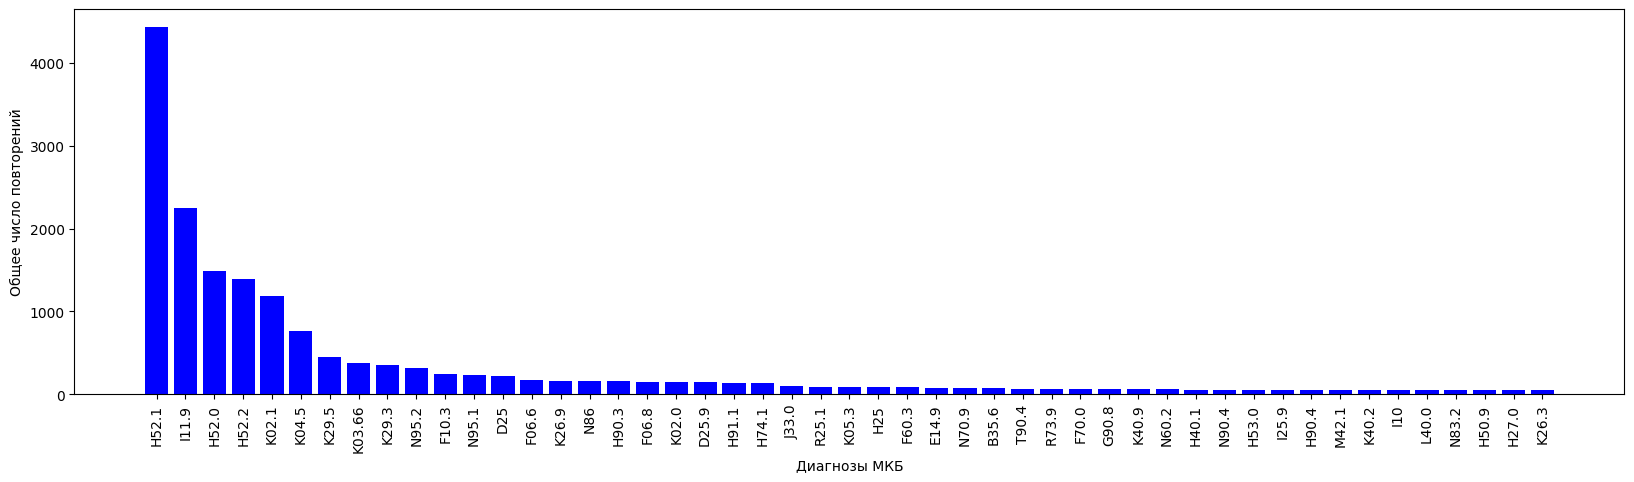

In [57]:
del u_mkb_sort_dict['Z00.0']
drawBarCountFactors(u_mkb_sort_dict, 'Диагнозы МКБ')

**Все МКБ, которые не попадают в выделенный диапазон 50-ти значений обозначаем как 'все остальные'.**

In [58]:
u_mkb_lst.clear()
u_mkb_lst = list(u_mkb_sort_dict.keys())
print()
print(f'{len(u_mkb_lst)}: u_mkb_lst: {u_mkb_lst}')

del u_mkb_sort_dict


49: u_mkb_lst: ['H52.1', 'I11.9', 'H52.0', 'H52.2', 'K02.1', 'K04.5', 'K29.5', 'K03.66', 'K29.3', 'N95.2', 'F10.3', 'N95.1', 'D25', 'F06.6', 'K26.9', 'N86', 'H90.3', 'F06.8', 'K02.0', 'D25.9', 'H91.1', 'H74.1', 'J33.0', 'R25.1', 'K05.3', 'H25', 'F60.3', 'E14.9', 'N70.9', 'B35.6', 'T90.4', 'R73.9', 'F70.0', 'G90.8', 'K40.9', 'N60.2', 'H40.1', 'N90.4', 'H53.0', 'I25.9', 'H90.4', 'M42.1', 'K40.2', 'I10', 'L40.0', 'N83.2', 'H50.9', 'H27.0', 'K26.3']


In [59]:
#~~~~~~~~~~~~~~~~~~~~~~~~
#multi_hot_encoding
mkb_mhe_lst = list()

# число классов
mkb_factors_class_count = len(u_mkb_lst) + 1
# то есть по умолчанию выбираем индекс мкб, которого нет в списке
# наших выбранных и ограниченных уникальных мкб: мкб=`все остальные`
nan_inx = len(u_mkb_lst)

# пробегаемся по всем строкам колонки
for i in range(len(mkb_lst)):
  i_elem = mkb_lst[i]
  # устанавливаем все признаки в нули
  i_mhe_lst = [0] * mkb_factors_class_count
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          # проверяем, есть ли этот элемент в списке
          if elem1_lst in u_mkb_lst:
            inx = u_mkb_lst.index(elem1_lst)
            i_mhe_lst[inx] = 1
          else:
            i_mhe_lst[nan_inx] = 1
      else:
        i_mhe_lst[nan_inx] = 1
    else:
      i_mhe_lst[nan_inx] = 1
  else:
    i_mhe_lst[nan_inx] = 1
  #~~~
  mkb_mhe_lst.append(i_mhe_lst)

df1 = df1.assign(ккДиагнозМКБ=mkb_mhe_lst)
del mkb_lst
del u_mkb_lst
del mkb_mhe_lst

print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (19813, 27)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккДиагнозМКБ,ккЦехПрофессия
19810,a62f9db2-c480-11ed-8115-0cc47aab8067,46b04d0b-b68b-11ed-8113-0cc47aab8067,1986-11-25T00:00:00,Мужской,Мужской,2023-03-17T00:00:00,Периодический,Периодический,False,33259f51-b11b-11ed-8111-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр|[H52.0] Гипер...,2,"[0, 0, 1]",36,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
19811,a5a350f7-6a33-11ed-8109-0cc47aab8067,2358bdac-013b-11ed-8103-0cc47aab8067,1969-06-25T00:00:00,Мужской,Мужской,2022-11-22T00:00:00,Периодический,Периодический,True,35a31340-fe89-11ec-8103-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр_x000D_|[H52.0...,1,"[0, 1, 0]",53,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
19812,ae6c023b-7213-11ed-810a-0cc47aab8067,1d50feca-013b-11ed-8103-0cc47aab8067,1988-06-03T00:00:00,Мужской,Мужской,2022-12-02T00:00:00,Периодический,Периодический,True,35a31340-fe89-11ec-8103-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр|[H52.2] Астиг...,2,"[0, 0, 1]",34,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,1,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN


## Текстовые признаки (Цех+Профессия: Tokenizer-Bag of Words)

**Cчитаю, что цех и профессию необходимо объединить в один признак.**

In [60]:
print(f'размеры датафрейма: df1: {df1.shape}')

print('Цех')
nan_lst = df1[df1['Цех'].isnull()].index
print(f'  число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['Цех'].unique().tolist()
print(f'  уникальные значения: {len(u_lst)}')

print('Профессия')
nan_lst = df1[df1['Профессия'].isnull()].index
print(f'  число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['Профессия'].unique().tolist()
print(f'  уникальные значения: {len(u_lst)}')

размеры датафрейма: df1: (19813, 27)
Цех
  число строк с пустыми значениями: 10962
  уникальные значения: 585
Профессия
  число строк с пустыми значениями: 0
  уникальные значения: 2840


In [61]:
# branch + profession
# результирующий список
brh_prn_lst = [""] * df1.shape[0]
# print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}, {brh_prn_lst}')

#~~~~~~~~~~~~~~~~~~~~~~~~
#~~~Цех
col_inx = df1.columns.get_loc('Цех')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'df1 число строк: {df1.shape[0]}, len(col_lst): {len(col_lst)}, {col_lst}')

for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}' )
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      i_elem2 = i_elem.lower().strip()
      # print(f'  i_elem2: {i_elem2}')
      brh_prn_lst[i] = i_elem2
    else:
      brh_prn_lst[i] = 'без отдела'
  else:
    brh_prn_lst[i] = 'без отдела'

# print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}, {brh_prn_lst}')

#~~~~~~~~~~~~~~~~~~~~~~~~
#~~~Профессия
col_inx = df1.columns.get_loc('Профессия')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'df1 число строк: {df1.shape[0]}, len(col_lst): {len(col_lst)}, {col_lst}')

for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}' )
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      i_elem2 = i_elem.lower().strip()
      # print(f'  i_elem2: {i_elem2}')
      brh_prn_lst[i] += ' ' + i_elem2

# print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}, {brh_prn_lst}')
print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}')
# пример цех+профессия 123-ей записи-строки
print(brh_prn_lst[123])

df1 число строк: 19813, len(brh_prn_lst): 19813
без отдела ведущий инженер


In [62]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

#определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#~"Сеанс прекращен, так как объем ОЗУ полностью исчерпан".
#~Поэтому уменьшаю текущее число ограничивающее вредные факторы
# maxWordsCount = 10000
# maxWordsCount = 700
maxWordsCount = 3000
# число строк: 3014, len(brh_prn_items): 765, [('unknown', 1), ('отдела', 2), ('без', 3), ('разряда', 4), ('водитель', 5), ('автомобиля', 6), ('по', 7), ('слесарь', 8), ('6', 9)

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

# "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
tokenizer.fit_on_texts(brh_prn_lst)

#Вытаскиваем индексы слов для просмотра
brh_prn_items = list(tokenizer.word_index.items())
print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_items): {len(brh_prn_items)}, {brh_prn_items}')

df1 число строк: 19813, len(brh_prn_items): 2301, [('unknown', 1), ('отдела', 2), ('без', 3), ('по', 4), ('инженер', 5), ('и', 6), ('водитель', 7), ('разряда', 8), ('отдел', 9), ('слесарь', 10), ('монтажник', 11), ('технологических', 12), ('оператор', 13), ('специалист', 14), ('участок', 15), ('машинист', 16), ('скважин', 17), ('ведущий', 18), ('категории', 19), ('ремонту', 20), ('ремонта', 21), ('повар', 22), ('цех', 23), ('уфа', 24), ('автомобиля', 25), ('5', 26), ('капитального', 27), ('трубопроводов', 28), ('6', 29), ('ооо', 30), ('служба', 31), ('начальник', 32), ('1', 33), ('старший', 34), ('главный', 35), ('продавец', 36), ('мастер', 37), ('установок', 38), ('2', 39), ('текущего', 40), ('менеджер', 41), ('группа', 42), ('4', 43), ('работ', 44), ('электромонтажник', 45), ('№2', 46), ('с', 47), ('на', 48), ('обслуживанию', 49), ('электромонтер', 50), ('025', 51), ('электрогазосварщик', 52), ('подразделение', 53), ('сервис', 54), ('помощник', 55), ('экспедитор', 56), ('в', 57), ('р

In [63]:
#преобразовываем текст в последовательность индексов согласно частотному словарю
#обучающие тесты в индексы
brh_prn_inxs = tokenizer.texts_to_sequences(brh_prn_lst)
print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_inxs): {len(brh_prn_inxs)}, {brh_prn_inxs}')

df1 число строк: 19813, len(brh_prn_inxs): 19813, [[365, 9, 188], [3, 2, 144], [3, 2, 16, 316], [3, 2, 7, 85], [3, 2, 11], [3, 2, 5, 244], [3, 2, 119], [3, 2, 7, 85], [3, 2, 7, 25, 43, 8], [51, 24, 91, 4, 187], [160, 53, 115, 124, 103], [3, 2, 11, 4, 1726, 81, 6, 84], [3, 2, 168, 411, 480], [3, 2, 35, 96], [3, 2, 11], [140, 145, 93, 249, 62, 641, 343], [23, 40, 6, 27, 21, 17, 46, 37, 4, 20, 17, 344, 425], [3, 2, 36, 251], [3, 2, 63, 679], [3, 2, 63], [855, 437], [42, 124, 91, 182], [3, 2, 10, 4, 20, 90, 88], [3, 2, 11, 12, 28], [3, 2, 5, 39, 19], [31, 1440, 438, 148, 201], [161, 162, 163, 164, 165, 158, 7, 25], [3, 2, 7, 492, 25], [3, 2, 856, 857], [3, 2, 5], [3, 2, 35, 5], [3, 2, 14, 317], [3, 2, 35, 14], [3, 2, 71, 149, 29, 8], [3, 2, 32, 138], [23, 40, 6, 27, 21, 17, 46, 117, 27, 21, 17], [3, 2, 86, 349], [3, 2, 11, 12, 28], [3, 2, 16, 129, 233, 218, 26, 8], [3, 2, 60], [326, 286, 269, 270, 22], [3, 2, 197, 58], [3, 2, 144], [3, 2, 252, 101], [3, 2, 16, 129, 233, 218, 26, 8], [3, 2,

In [64]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
# Подаем xTrain в виде списка чтобы метод успешно сработал
xTrainProf01 = tokenizer.sequences_to_matrix(brh_prn_inxs)
# Размер обучающей выборки, сформированной по Bag of Words
print(xTrainProf01.shape)
print(f'xTrainProf01 число строк : {xTrainProf01.shape[0]}')
print(f'xTrainProf01 число столбцов : {xTrainProf01.shape[1]}')
print(xTrainProf01[0][0:100])

(19813, 3000)
xTrainProf01 число строк : 19813
xTrainProf01 число столбцов : 3000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [65]:
n = 123
# Цех+Профессия
print(brh_prn_lst[n])
# Профессия через индексы
print(brh_prn_inxs[n])

без отдела ведущий инженер
[3, 2, 18, 5]


In [66]:
brh_mhe_lst = xTrainProf01.astype(int).tolist()
# print(f'df1 число строк: {df1.shape[0]}, len(brh_mhe_lst): {len(brh_mhe_lst)}, {brh_mhe_lst}')

df1 = df1.assign(ккЦехПрофессия=brh_mhe_lst)
del brh_prn_lst
del brh_mhe_lst
del brh_prn_inxs
del xTrainProf01


print(f'размеры датафрейма df1: {df1.shape}')
print('='*50)
df1.tail(3)

размеры датафрейма df1: (19813, 27)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккДиагнозМКБ,ккЦехПрофессия
19810,a62f9db2-c480-11ed-8115-0cc47aab8067,46b04d0b-b68b-11ed-8113-0cc47aab8067,1986-11-25T00:00:00,Мужской,Мужской,2023-03-17T00:00:00,Периодический,Периодический,False,33259f51-b11b-11ed-8111-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр|[H52.0] Гипер...,2,"[0, 0, 1]",36,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19811,a5a350f7-6a33-11ed-8109-0cc47aab8067,2358bdac-013b-11ed-8103-0cc47aab8067,1969-06-25T00:00:00,Мужской,Мужской,2022-11-22T00:00:00,Периодический,Периодический,True,35a31340-fe89-11ec-8103-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр_x000D_|[H52.0...,1,"[0, 1, 0]",53,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19812,ae6c023b-7213-11ed-810a-0cc47aab8067,1d50feca-013b-11ed-8103-0cc47aab8067,1988-06-03T00:00:00,Мужской,Мужской,2022-12-02T00:00:00,Периодический,Периодический,True,35a31340-fe89-11ec-8103-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр|[H52.2] Астиг...,2,"[0, 0, 1]",34,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,1,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Итоговый датафрейм, число пропусков

In [67]:
print(f'размеры датафрейма df1: {df1.shape}')
print(f'  число строк: {df1.shape[0]}')
print(f'  число колонок: {df1.shape[1]}')
print('='*50)
nan_cell_count = df1.isna().sum().sum()
nan_cell_count_proc = nan_cell_count*100/df1.size
print(f'общее количество пропусков во всей таблице (колонка цех): {nan_cell_count}, {round(nan_cell_count_proc, 2)}%')

размеры датафрейма df1: (19813, 27)
  число строк: 19813
  число колонок: 27
общее количество пропусков во всей таблице (колонка цех): 11527, 2.15%


# Обучение Нейросети

## Создаем выборки для обучения и проверки нейросети

In [68]:
# Переменные-настройки-параметры-для-обучения-сети
# TEST_DATA_SIZE, VALID_DATA_SIZE in percent value: 0..1
TEST_DATA_SIZE = 0.20
VALID_DATA_SIZE = 0.20
#~~~~~~~~~~~~~~~~~~~~~~~~
print(f'TEST_DATA_SIZE: {TEST_DATA_SIZE}')
print(f'VALID_DATA_SIZE: {VALID_DATA_SIZE}')

TEST_DATA_SIZE: 0.2
VALID_DATA_SIZE: 0.2


In [69]:
# y_data - one-hot-encoding целевой массив результатов
df_y = df1['ккЗаключениеМК'].apply(pd.Series)
print(f'размеры датафрейма df_y: {df_y.shape}')
print('='*50)
df_y.tail(3)

размеры датафрейма df_y: (19813, 3)


,0,1,2
19810,0,0,1
19811,0,1,0
19812,0,0,1


In [70]:
# преобразуем в numpy массив типа float
# y_data = df_y.astype(float).to_numpy()
y_data = df_y.astype(np.float32).to_numpy()

print('y_data:')
print(f'  количество осей: {y_data.ndim}')
print(f'  форма массива: {y_data.shape}')
print(f'  количество значений: {y_data.size}')
del df_y

y_data:
  количество осей: 2
  форма массива: (19813, 3)
  количество значений: 59439


In [71]:
# x_data - массив категориальных колонок
df_x = df1.drop(['ДокументПрохождениеМедосмотра',
                 'Клиент',
                 'КлиентДатаРождения',
                 'КлиентПол',
                 'КлиентПолПредставление',
                 'ДатаЗавершенияМедосмотра',
                 'ТипМедосмотра',
                 'ТипМедосмотраПредставление',
                 'ПсихОсвидетельствование',
                 'Контрагент',
                 'Цех',
                 'Профессия',
                 'ЗаключениеМК',
                 'ЗаключениеМКПредставление',
                 'Заключение',
                 'ВредныеФакторы',
                 'ДиагнозМКБ',
                 'ДиагнозОписание',
                 'кЗаключениеМК',
                 'кВозраст'
                 ], axis = 1)

print(f'размеры датафрейма df_x: {df_x.shape}')
print('='*50)
df_x.tail(3)

размеры датафрейма df_x: (19813, 7)


,ккЗаключениеМК,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккДиагнозМКБ,ккЦехПрофессия
19810,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19811,"[0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19812,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,1,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [72]:
# трансформируем one-multi-hot-encoding списки в отдельные колонки
split_col_names = list()
#~~~~~~~~~~~~~~~~~~~~~~~~
split_col_names.append('ккЗаключениеМК')
split_col_names.append('ккВозраст')
split_col_names.append('ккВредныеФакторы')
split_col_names.append('ккДиагнозМКБ')
split_col_names.append('ккЦехПрофессия')
#~~~~~~~~~~~~~~~~~~~~~~~~

for col_name in split_col_names:
  df_x = pd.concat([df_x.drop(col_name, axis=1), df_x[col_name].apply(pd.Series)], axis=1)

del split_col_names

print(f'размеры датафрейма df_x: {df_x.shape}')
print('='*50)
df_x.tail(3)

размеры датафрейма df_x: (19813, 3117)


,кКлиентПол,кПсихОсвидетельствование,0,1,2,0,1,2,3,4,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
19810,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
19811,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19812,1,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [73]:
# преобразуем в numpy массив типа float
# x_data = df_x.astype(float).to_numpy()
x_data = df_x.astype(np.float32).to_numpy()

print('x_data:')
print(f'  количество осей: {x_data.ndim}')
print(f'  форма массива: {x_data.shape}')
print(f'  количество значений: {x_data.size}')

x_data_row, x_data_col = x_data.shape
print(f'  число строк: {x_data_row}')
print(f'  число колонок: {x_data_col}')

del df_x

x_data:
  количество осей: 2
  форма массива: (19813, 3117)
  количество значений: 61757121
  число строк: 19813
  число колонок: 3117


Разделяю датасет на две части: первые 20% (TEST_DATA_SIZE) записей - тестовая выборка, оставшиеся 80% (1.0 - TEST_DATA_SIZE) - выборка для обучения, которую в свою очередь также разделяю на две части, выделяя 20% (VALID_DATA_SIZE) на корректировку обучения. Тестовая выборка не участвует в обучении, она необходима только для проверки результатов.

In [74]:
test_count = int(x_data_row*TEST_DATA_SIZE)
print(f'test_count: {test_count}')

test_count: 3962


In [75]:
x_test = x_data[:test_count]
y_test = y_data[:test_count]
print('x_test:')
print(f'  количество осей: {x_test.ndim}')
print(f'  форма массива: {x_test.shape}')
print(f'  количество значений: {x_test.size}')
print('y_test:')
print(f'  количество осей: {y_test.ndim}')
print(f'  форма массива: {y_test.shape}')
print(f'  количество значений: {y_test.size}')

x_test:
  количество осей: 2
  форма массива: (3962, 3117)
  количество значений: 12349554
y_test:
  количество осей: 2
  форма массива: (3962, 3)
  количество значений: 11886


In [76]:
x_train = x_data[test_count:]
y_train = y_data[test_count:]
print('x_train:')
print(f'  количество осей: {x_train.ndim}')
print(f'  форма массива: {x_train.shape}')
print(f'  количество значений: {x_train.size}')
print('y_train:')
print(f'  количество осей: {y_train.ndim}')
print(f'  форма массива: {y_train.shape}')
print(f'  количество значений: {y_train.size}')

del x_data
del y_data

x_train:
  количество осей: 2
  форма массива: (15851, 3117)
  количество значений: 49407567
y_train:
  количество осей: 2
  форма массива: (15851, 3)
  количество значений: 47553


## Обучение нейронной сети

In [77]:
# Переменные-настройки-параметры-для-обучения-сети
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
EPOCHS = 50
VERBOSE = 1
#~~~~~~~~~~~~~~~~~~~~~~~~
print(f'LEARNING_RATE: {LEARNING_RATE}')
print(f'BATCH_SIZE: {BATCH_SIZE}')
print(f'EPOCHS: {EPOCHS}')
print(f'VERBOSE: {VERBOSE}')

LEARNING_RATE: 0.001
BATCH_SIZE: 128
EPOCHS: 50
VERBOSE: 1


In [78]:
# Графическое представление результатов работы нейросети
#~~~~~~~~~~~~~~~~~~~~~~~~
def printNNChart(history_n):
  '''
    Отображенние на графике результатов работы нейронной сети (Neural Network)
    вход:
        history_n: массив результатов работы нейросети
  '''
  # Создание полотна для рисунка
  plt.figure(figsize=(18,5))

  # Задание первой (левой) области для построения графиков
  plt.subplot(1, 2, 1)
  # Отрисовка графиков 'loss' и 'val_loss' из значений словаря history.history
  plt.plot(history_n.history['loss'],
           color='blue',
           label = 'Значение ошибки на обучающем наборе')
  plt.plot(history_n.history['val_loss'],
           color='red',
           label = 'Значение ошибки на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Значение ошибки')
  plt.legend()
  plt.grid(which = 'major', color = 'black', alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

  # Задание второй (правой) области для построения графиков
  plt.subplot(1, 2, 2)
  # Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря history.history
  plt.plot(history_n.history['accuracy'],
           color='blue',
           label = 'Доля верных ответов на обучающем наборе')
  plt.plot(history_n.history['val_accuracy'],
           color='red',
           label = 'Доля верных ответов на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.grid(which = 'major', color = 'black', alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

  # Фиксация графиков и рисование всей картинки
  plt.show()

In [79]:
# Создание модели
model1 = Sequential()

# Добавление слоев
model1.add(Dense(60, input_dim=x_train.shape[1], activation='relu'))

model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(30))

model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(10))

model1.add(Dense(3, activation = 'softmax'))

In [80]:
# Компиляция
model1.compile(loss='categorical_crossentropy',
               optimizer=Adam(learning_rate=LEARNING_RATE),
               metrics=['accuracy'])

In [81]:
# Обучение нейронной сети
history1 = model1.fit(x_train,                             # Обучающая выборка параметров
                      y_train,                             # Обучающая выборка целевого результата
                      batch_size=BATCH_SIZE,               # Размер батча (пакета)
                      epochs=EPOCHS,                       # Количество эпох обучения
                      validation_split=VALID_DATA_SIZE,    # Доля валидационной-корректирующей выборки
                      verbose=VERBOSE)                     # Отображение хода обучения

Epoch 1/50
100/100 [==============================] - 3s 13ms/step - loss: 0.2185 - accuracy: 0.9308 - val_loss: 0.4424 - val_accuracy: 1.0000
Epoch 2/50
100/100 [==============================] - 1s 9ms/step - loss: 0.0103 - accuracy: 0.9998 - val_loss: 0.2108 - val_accuracy: 1.0000
Epoch 3/50
100/100 [==============================] - 1s 10ms/step - loss: 0.0041 - accuracy: 0.9999 - val_loss: 0.0644 - val_accuracy: 1.0000
Epoch 4/50
100/100 [==============================] - 1s 10ms/step - loss: 0.0035 - accuracy: 0.9995 - val_loss: 0.0144 - val_accuracy: 1.0000
Epoch 5/50
100/100 [==============================] - 1s 10ms/step - loss: 0.0071 - accuracy: 0.9989 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 6/50
100/100 [==============================] - 1s 9ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 5.4044e-04 - val_accuracy: 1.0000
Epoch 7/50
100/100 [==============================] - 1s 10ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 2.4331e-04 - val_accuracy: 

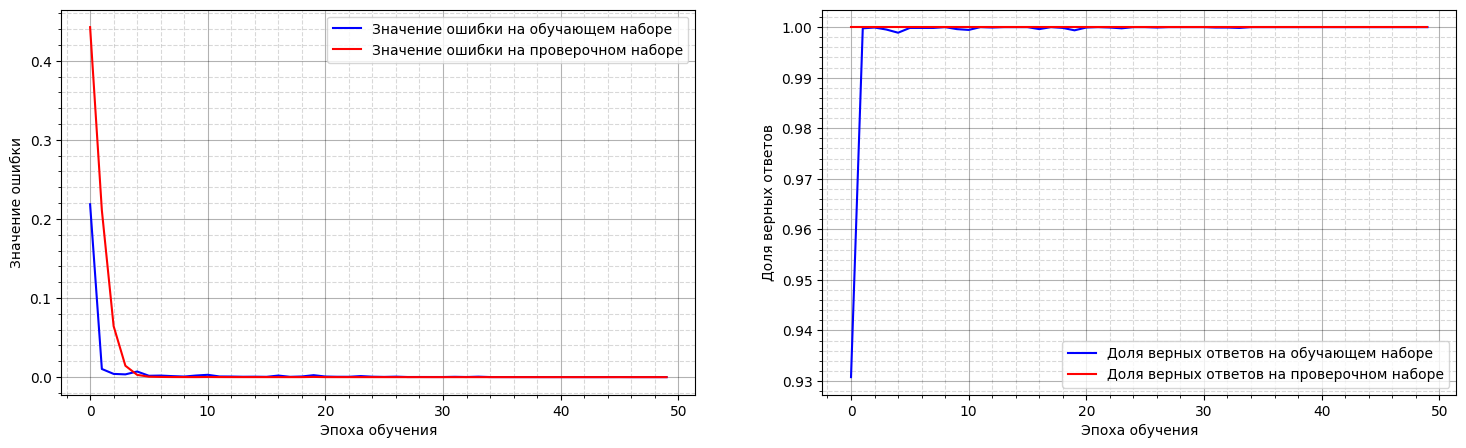

In [82]:
# Отобразим результаты на графике
printNNChart(history1)

## Оценка результатов

In [83]:
# Оценим результат работы нашей сети.
# Применим метод .evaluate() к нашей модели, в качестве параметров
# передадим ему тестовые выборки и согласие на отображение хода вычисления.

scores1 = model1.evaluate(x_test,
                          y_test,
                          verbose=1)

print('Процент верных ответов на тестовых данных:', round(scores1[1],2) * 100, '%')

124/124 [==============================] - 0s 2ms/step - loss: 6.9066e-05 - accuracy: 1.0000
Процент верных ответов на тестовых данных: 100.0 %


In [84]:
# Вывод значения точности распознавания на проверочной выборке по эпохам
val_acc1 = history1.history['val_accuracy']
i_max = 0
val_acc_max = -1.0
# print(f'Эпохи: {EPOCHS}')
for i in range(EPOCHS):
  # print(f'  {i}->{EPOCHS}: {round(val_acc1[i], 3)}%')
  if val_acc1[i] > val_acc_max:
    val_acc_max = val_acc1[i]
    i_max = i

print(f'Нейронная сеть под номером: {i_max} из {EPOCHS} эпох')
print(f'  достигла точности: {round(val_acc1[i]*100., 3)}%')

Нейронная сеть под номером: 0 из 50 эпох
  достигла точности: 100.0%


# Оценка предсказаний по тестовой выборке

In [85]:
# Распознавание ЗаключениеМК на тестовой выборке
# x_test, y_test -> массивы, которые не принимали участия в обучении нейронки
print('x_test, y_test -> массивы, которые не принимали участия в обучении нейронки:')
print('x_test:')
print(f'  количество осей: {x_test.ndim}')
print(f'  форма массива: {x_test.shape}')
print(f'  количество значений: {x_test.size}')
print('y_test:')
print(f'  количество осей: {y_test.ndim}')
print(f'  форма массива: {y_test.shape}')
print(f'  количество значений: {y_test.size}')

x_test, y_test -> массивы, которые не принимали участия в обучении нейронки:
x_test:
  количество осей: 2
  форма массива: (3962, 3117)
  количество значений: 12349554
y_test:
  количество осей: 2
  форма массива: (3962, 3)
  количество значений: 11886


In [86]:
pred1 = model1.predict(x_test)

# У нас три класса:
# 0 - не годен, 1 - ограниченно годен, 2 - годен
# Подсчитаем по каждому верное и неверное предсказания
arr_true = np.zeros(3, dtype=int)
arr_false = np.zeros(3, dtype=int)

for i in range(y_test.shape[0]):
  # Получение индекса самого большого элемента
  # потому что мы имеем дело с one-hot-encoding, поэтому необходимо
  # определить элемент в массиве с максимальным значением,
  # индекс этого элемента и будет говорить о верном элементе
  #~индекс тестового элемента
  y_inx_max = np.argmax(y_test[i,:])
  #~индекс предсказанного элемента
  pred_inx_max = np.argmax(pred1[i,:])
  #~~~
  if y_inx_max == pred_inx_max:
    # верное предсказание
    arr_true[y_inx_max] += 1
  else:
    # неверное предсказания
    arr_false[y_inx_max] += 1

# Результаты предсказаний по тестовой выборке
print('Результаты предсказаний по тестовой выборке:')
print(f'  размер тествой выборки: {y_test.shape[0]}')
print(f'  0 - не годен, предсказания:')
print(f'     верное: {arr_true[0]}')
print(f'     неверное: {arr_false[0]}')
print(f'  1 - ограниченно годен, предсказания:')
print(f'     верное: {arr_true[1]}')
print(f'     неверное: {arr_false[1]}')
print(f'  2 - годен:')
print(f'     верное: {arr_true[2]}')
print(f'     неверное: {arr_false[2]}')
print(f'  проверочная сумма (сумма всех значений): {y_test.shape[0]} = {arr_true[0]+arr_false[0]+arr_true[1]+arr_false[1]+arr_true[2]+arr_false[2]}')

124/124 [==============================] - 0s 3ms/step
Результаты предсказаний по тестовой выборке:
  размер тествой выборки: 3962
  0 - не годен, предсказания:
     верное: 616
     неверное: 0
  1 - ограниченно годен, предсказания:
     верное: 864
     неверное: 0
  2 - годен:
     верное: 2482
     неверное: 0
  проверочная сумма (сумма всех значений): 3962 = 3962


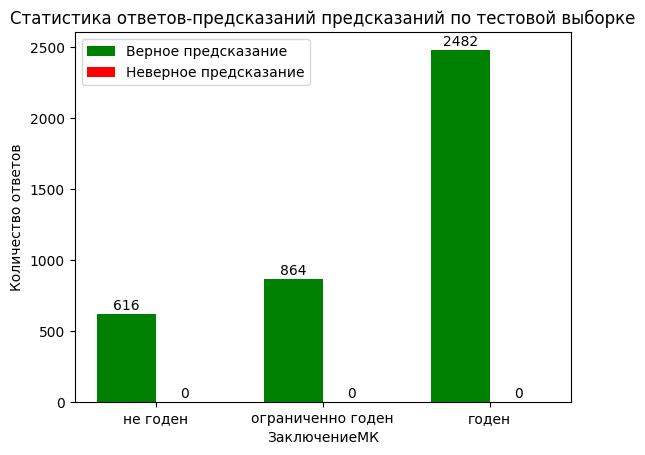

In [87]:
fig, ax = plt.subplots()

conclusion_lst = ['не годен', 'ограниченно годен', 'годен']
index = np.arange(len(conclusion_lst))
bar_width = 0.35

rects1 = ax.bar(index, arr_true, bar_width, color='g', label='Верное предсказание')
rects2 = ax.bar(index + bar_width, arr_false, bar_width, color='r', label='Неверное предсказание')

ax.set_xlabel('ЗаключениеМК')
ax.set_ylabel('Количество ответов')
ax.set_title('Статистика ответов-предсказаний предсказаний по тестовой выборке')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(conclusion_lst)

ax.legend()

for rect, value in zip(rects1, arr_true):
    height = rect.get_height()
    ax.annotate('{}'.format(value),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 1),
                textcoords="offset points",
                ha='center', va='bottom')

for rect, value in zip(rects2, arr_false):
    height = rect.get_height()
    ax.annotate('{}'.format(value),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 1),
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

# Приказ №29Н Министерства здравоохранения Российской Федерации

https://normativ.kontur.ru/document?moduleId=1&documentId=416520

"МИНИСТЕРСТВО ЗДРАВООХРАНЕНИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ
ПРИКАЗ
от 28 января 2021 г. N 29н
ОБ УТВЕРЖДЕНИИ ПОРЯДКА ПРОВЕДЕНИЯ ОБЯЗАТЕЛЬНЫХ ПРЕДВАРИТЕЛЬНЫХ И ПЕРИОДИЧЕСКИХ МЕДИЦИНСКИХ ОСМОТРОВ РАБОТНИКОВ, ПРЕДУСМОТРЕННЫХ ЧАСТЬЮ ЧЕТВЕРТОЙ СТАТЬИ 213 ТРУДОВОГО КОДЕКСА РОССИЙСКОЙ ФЕДЕРАЦИИ, ПЕРЕЧНЯ МЕДИЦИНСКИХ ПРОТИВОПОКАЗАНИЙ К ОСУЩЕСТВЛЕНИЮ РАБОТ С ВРЕДНЫМИ И (ИЛИ) ОПАСНЫМИ ПРОИЗВОДСТВЕННЫМИ ФАКТОРАМИ, А ТАКЖЕ РАБОТАМ, ПРИ ВЫПОЛНЕНИИ КОТОРЫХ ПРОВОДЯТСЯ ОБЯЗАТЕЛЬНЫЕ ПРЕДВАРИТЕЛЬНЫЕ И ПЕРИОДИЧЕСКИЕ МЕДИЦИНСКИЕ ОСМОТРЫ"

"Приложение N 2
к приказу Министерства здравоохранения
Российской Федерации
от 28 января 2021 г. N 29н

ПЕРЕЧЕНЬ МЕДИЦИНСКИХ ПРОТИВОПОКАЗАНИЙ К РАБОТАМ С ВРЕДНЫМИ И (ИЛИ) ОПАСНЫМИ ПРОИЗВОДСТВЕННЫМИ ФАКТОРАМИ, А ТАКЖЕ РАБОТАМ, ПРИ ВЫПОЛНЕНИИ КОТОРЫХ ПРОВОДЯТСЯ ОБЯЗАТЕЛЬНЫЕ ПРЕДВАРИТЕЛЬНЫЕ И ПЕРИОДИЧЕСКИЕ МЕДИЦИНСКИЕ ОСМОТРЫ"

**Использую Приложение №2 для дополнения вердикта мнением, почему человек не годен, или почему ограниченно годен.**

## Словарь-датафрейм болезней

Поля в таблице Приложения 2:

- Наименование болезней, степень нарушения функции организма,
- Код по МКБ-10,
- Вредные и (или) опасные производственные факторы,
- Виды работ

Дополнительно таблица Приложения 2 поделена на 17 классов болезней, по числу которых трансформировал оригинальный документ в текстовые-csv файлы с разделителем '|'.

In [291]:
# Создаем списки-классификаторы, которые потом будем использовать для пояснения решения
class29_lst = list()
class29_lst.append("Класс I. Некоторые инфекционные и паразитарные болезни")
class29_lst.append("Класс II. Новообразования")
class29_lst.append("Класс III. Болезни крови, кроветворных органов и отдельные нарушения, вовлекающие иммунный механизм")
class29_lst.append("Класс IV. Болезни эндокринной системы, расстройства питания, нарушения обмена веществ")
class29_lst.append("Класс V. Психические расстройства и расстройства поведения - по перечням и в порядке, утвержденным Правительством Российской Федерации")
class29_lst.append("Класс VI. Болезни нервной системы")
class29_lst.append("Класс VII. Болезни глаза и его придаточного аппарата")
class29_lst.append("Класс VIII. Болезни уха и сосцевидного отростка")
class29_lst.append("Класс IX. Болезни системы кровообращения")
class29_lst.append("Класс X. Болезни органов дыхания")
class29_lst.append("Класс XI. Болезни органов пищеварения")
class29_lst.append("Класс XII. Болезни кожи и подкожной клетчатки")
class29_lst.append("Класс XIII. Болезни костно-мышечной системы и соединительной ткани")
class29_lst.append("Класс XIV. Болезни мочеполовой системы")
class29_lst.append("Класс XV. Беременность, роды и послеродовой период")
class29_lst.append("Класс XVII. Врожденные аномалии, деформации и хромосомные нарушения")
class29_lst.append("Класс XIX. Травмы, отравления и некоторые другие последствия воздействий внешних причин")

#~~~~~~~~~~~~~~~~~~~~~~~~
# Создаю датафрейм из приложения 2 приказа №29Н
#~префикс к - код в колонках датафрейма
df29 = pd.DataFrame(columns=['Класс', 'Болезнь', 'МКБ10', 'ВредФакторы', 'ВидыРабот', 'кМКБ10', 'кВредФакторы'])
df29['Класс'] = df29['Класс'].astype(int)
df29['Болезнь'] = df29['Болезнь'].astype(str)
df29['МКБ10'] = df29['МКБ10'].astype(str)
df29['ВредФакторы'] = df29['ВредФакторы'].astype(str)
df29['ВидыРабот'] = df29['ВидыРабот'].astype(str)
df29['кМКБ10'] = df29['кМКБ10'].astype(str)
df29['кВредФакторы'] = df29['кВредФакторы'].astype(str)

print(f'размеры датафрейма df29: {df29.shape}')
print('='*50)
df29.tail(3)

размеры датафрейма df29: (0, 7)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот,кМКБ10,кВредФакторы


## Загрузка 17 текстовых файлов классов болезней

In [292]:
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=180prezoaEESrwOpYu7PgOHjytbZ4AceL', None, quiet=True)

'mkb10_disease.zip'

In [293]:
dir_name_29 = '/content/mkb10_disease'
fn_29 = dir_name_29 + '/prikazN29H_2-1.txt'
# разворачиваем архив,
# чтобы система не спрашивала 'перезаписать файлы или нет',
# если архив был развернут в предыдущий запуск, делаю проверку
# на существование файлов на диске ихз архива
if not os.path.exists(fn_29):
  !unzip -q mkb10_disease.zip

# смотрим список файлов
!ls '/content/mkb10_disease'

prikazN29H_2-10.txt  prikazN29H_2-17.txt  prikazN29H_2-5.txt
prikazN29H_2-11.txt  prikazN29H_2-19.txt  prikazN29H_2-6.txt
prikazN29H_2-12.txt  prikazN29H_2-1.txt   prikazN29H_2-7.txt
prikazN29H_2-13.txt  prikazN29H_2-2.txt   prikazN29H_2-8.txt
prikazN29H_2-14.txt  prikazN29H_2-3.txt   prikazN29H_2-9.txt
prikazN29H_2-15.txt  prikazN29H_2-4.txt


## Обработка 17 текстовых файлов классов болезней

In [294]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Дополнение левого МКБ по полного формата
#~~~~~~~~~~~~~~~~~~~~~~~~
def patch_mkb29_left_postfix(mkb29_code):
  '''
    Дополнение левого МКБ по полного формата: A00 -> A00.0, A00.4 -> A00.4,
    вход:
        mkb29_code: строка вида A00, A00.4
    выход:
        retVal: левого МКБ по полного формата
  '''
  retVal = mkb29_code.strip()
  if not ("." in retVal):
    retVal = retVal + '.0'

  return retVal

In [295]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Дополнение правого МКБ по полного формата
#~~~~~~~~~~~~~~~~~~~~~~~~
def patch_mkb29_right_postfix(mkb29_code):
  '''
    Дополнение правого МКБ по полного формата: A00 -> A00.9, A00.4 -> A00.4,
    вход:
        mkb29_code: строка вида A00, A00.4
    выход:
        retVal: дополненный правого МКБ по полного формата
  '''
  retVal = mkb29_code.strip()
  if not ("." in retVal):
    retVal = retVal + '.9'

  return retVal

In [296]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Дополнение МКБ диапазона по одному коду
#~~~~~~~~~~~~~~~~~~~~~~~~
def patch_mkb29_list1(mkb29_code):
  '''
    Дополнение МКБ диапазона: A00 -> A00.0,A00.1,A00.2,A00.3,A00.4,A00.5,A00.6,A00.7,A00.8,A00.9
                              A00.4 -> A00.4
    вход:
        mkb29_code: строка вида A00, A00.4
    выход:
        retVal: список, дополненный до полного формата
  '''
  retVal = list()
  str1 = mkb29_code.strip()
  if "." in str1:
    retVal.append(str1)
  else:
    for i in range(10):
      str2 = str(i)
      str3 = str1 + '.' + str2
      retVal.append(str3)

  return retVal

In [297]:
def mkb29_num_format(mkb29_num):
  '''
    Форматирование числа мкб в строку мкб
    вход:
        mkb29_num: число мкб
    выход:
        retVal: строка мкб
  '''
  retVal = "{:04.1f}".format(mkb29_num)
  return retVal

In [298]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Дополнение МКБ диапазона начальному и конечному коду
#~~~~~~~~~~~~~~~~~~~~~~~~
def patch_mkb29_list2(mkb29_code1, mkb29_code2):
  '''
    Дополнение МКБ диапазона по начальному и конечному значениям
    вход:
        mkb29_code1: начальный код
        mkb29_code2: конечный код
    выход:
        retVal: список, дополненный до полного формата
  '''
  retVal = list()
  str1 = patch_mkb29_left_postfix(mkb29_code1)
  str2 = patch_mkb29_right_postfix(mkb29_code2)
  str1_prefix = str1[:1]
  str2_prefix = str2[:1]
  str1_postfix = str1[1:]
  str2_postfix = str2[1:]
  # print(f'str1: {str1}, str1_prefix: {str1_prefix}')
  # print(f'str2: {str2}, str2_prefix: {str2_prefix}')
  if not str1_prefix == str2_prefix:
    if '0' == str2_prefix or '1' == str2_prefix or '2' == str2_prefix or '3' == str2_prefix or '4' == str2_prefix or '5' == str2_prefix or '6' == str2_prefix or '7' == str2_prefix or '8' == str2_prefix or '9' == str2_prefix:
       str2_prefix = str1_prefix
       str2_postfix = str2
    else:
      print(f'ОШИБКА: неверные префиксы: {mkb29_code1}, {mkb29_code2}')
      return retVal

  #~~~~~~~~~~~~~~~~~~~~~~~~
  num1 = float(str1_postfix)
  num2 = float(str2_postfix)
  # print(f'str1_postfix: {str1_postfix}, num1: {num1}')
  # print(f'str2_postfix: {str2_postfix}, num2: {num2}')

  num_delta = num2 - num1
  num_step = num_delta/0.1
  r_num_step = round(num_step)
  i_num_step = int(r_num_step)
  # print(f'num_delta: {num_delta}, num_step: {num_step}, r_num_step: {r_num_step}, i_num_step: {i_num_step}')
  i_num_step += 1
  # print(f'  i_num_step: {i_num_step}')

  #~~~~~~~~~~~~~~~~~~~~~~~~
  for i in range(i_num_step):
    f_step = float(i)
    num2 = num1 + f_step*0.1
    # print(f'{i}->{i_num_step}: num2: {num2}')
    str3 = mkb29_num_format(num2)
    str4 = str1_prefix + str3
    # print(f'  str1_prefix: {str1_prefix}, str3: {str3}, str4: {str4}')
    retVal.append(str4)
    # print(f'  num1: {num1}')

  return retVal

In [299]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки `Код по МКБ-10` из приказа 29 по запятым и минусам
#~~~~~~~~~~~~~~~~~~~~~~~~
def mkb29_split(arg):
  '''
    Расщепление строки по запятым и минусам, удаление пробелов перед словом и после
    вход:
        arg: строка с запятыми или без запятых, с минусами или без
    выход:
        retVal: список строк
  '''
  # print(f'mkb29_split> arg: {arg}')

  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # удаляем пробелы в начале и конце слова
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      # print(f' str_lst1>: {len(str_lst1)}: {str_lst1}')
      str_lst2 = list()
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          # проверям строку на минус
          str_lst2.clear()
          if str_item2.find('-') >= 0:
            str_lst3 = str_item2.split('-')
            str_item31 = str_lst3[0].strip()
            str_item32 = str_lst3[1].strip()
            str_lst2 = patch_mkb29_list2(str_item31, str_item32)
          else:
            # значение не содержит минус, то есть не диапазон
            str_lst2 = patch_mkb29_list1(str_item2)
          #~~~
          if len(str_lst2) > 0:
            for str2 in str_lst2:
              retVal.append(str2)

  # print(f'    retVal: {retVal}')
  return retVal

In [300]:
def addClassToAccumulator29(file_name29, class29_inx, df_29):
  '''
    Чтение текстового файла и добавление его значений по спискам
    вход:
        file_name29: имя текстового файла
        class29_inx: индекс класса в списке class29_lst0
    выход:
        df_29: дополненный дата фрейм
  '''
  # чтение файла и создание списка строк
  # with open('/content/'+file_name29, 'r') as file29:
  with open(file_name29, 'r') as file29:
    lines29 = file29.readlines()

  for i in range(len(lines29)):
    # print(f'{i}->{len(lines29)}: {lines29[i]}')
    str1 = lines29[i].strip()
    # разбиваем строку по вертикальным линиям
    str_lst1 = str1.split('|')
    if 4 == len(str_lst1):
      # 0: `а) Активный туберкулез.... `
      # 1: `A15 - A19`
      # 2: `1 - 5`
      # 3: `6 - 27`
      #~~~0 ~ Наименование болезней
      diseases29_str = str_lst1[0].strip()
      #~~~1 ~ МКБ-10
      mkb29_str1 = str_lst1[1].strip()
      mkb29_lst = mkb29_split(mkb29_str1)
      if len(mkb29_lst) < 1:
        print(f'ОШИБКА: неверное значение МКБ: {file_name29}')
        continue
      mkb29_str2 = ",".join(mkb29_lst)
      #~~~2 ~ Вредные факторы
      hf29_str1 = str_lst1[2].strip()
      hf29_str2 = ''
      #~~~3 ~ Виды работ
      job_type29_str = str_lst1[3].strip()
      #~~~~~~~~~~~~~~~~~~~~~~~~
      #~~~~добавляю сформированные строки в датафрейм
      newrow_29 = {'Класс': class29_inx, 'Болезнь': diseases29_str, 'МКБ10': mkb29_str1, 'ВредФакторы': hf29_str1, 'ВидыРабот': job_type29_str, 'кМКБ10': mkb29_str2, 'кВредФакторы': hf29_str2}
      df_29 = pd.concat([df_29, pd.DataFrame(newrow_29, index=[0])], ignore_index=True)
    else:
      print(f'ОШИБКА: неверное число данных в колонках: {file_name29}')

  return df_29

In [301]:
# Формирую-создаю датафрейм из приложения 2 приказа №29Н
print(f'число классов: {len(class29_lst)}')
for i in range(len(class29_lst)):
  print()
  print('-'*50)
  print(f'{i}: {class29_lst[i]}')
  j = i + 1
  if 15 == i:
    j = 17
  elif 16 == i:
    j = 19
  #~~~
  fn_29 = dir_name_29 + '/prikazN29H_2-' + str(j) + '.txt'
  print(f'fn_29: `{fn_29}`')
  #~~~
  df29 = addClassToAccumulator29(fn_29, i, df29);
  print(f'размеры датафрейма: df29: {df29.shape}')
  # print(df29.tail(2))

число классов: 17

--------------------------------------------------
0: Класс I. Некоторые инфекционные и паразитарные болезни
fn_29: `/content/mkb10_disease/prikazN29H_2-1.txt`
размеры датафрейма: df29: (7, 7)

--------------------------------------------------
1: Класс II. Новообразования
fn_29: `/content/mkb10_disease/prikazN29H_2-2.txt`
размеры датафрейма: df29: (15, 7)

--------------------------------------------------
2: Класс III. Болезни крови, кроветворных органов и отдельные нарушения, вовлекающие иммунный механизм
fn_29: `/content/mkb10_disease/prikazN29H_2-3.txt`
размеры датафрейма: df29: (20, 7)

--------------------------------------------------
3: Класс IV. Болезни эндокринной системы, расстройства питания, нарушения обмена веществ
fn_29: `/content/mkb10_disease/prikazN29H_2-4.txt`
размеры датафрейма: df29: (23, 7)

--------------------------------------------------
4: Класс V. Психические расстройства и расстройства поведения - по перечням и в порядке, утвержденным Пр

In [302]:
print(f'размеры датафрейма df29: {df29.shape}')
print('='*50)
df29.tail(3)

размеры датафрейма df29: (134, 7)


,Класс,Болезнь,МКБ10,ВредФакторы,ВидыРабот,кМКБ10,кВредФакторы
131,16,а) лучевая болезнь,T66 - T70,1 - 5,6 - 22,"T66.0,T66.1,T66.2,T66.3,T66.4,T66.5,T66.6,T66....",
132,16,"б) вибрационная болезнь, стойкие и выраженные ...",T66 - T70,"1, 4",,"T66.0,T66.1,T66.2,T66.3,T66.4,T66.5,T66.6,T66....",
133,16,"Последствия травм, отравлений, других воздейст...",T90 - T98,1 - 5,6 - 22,"T90.0,T90.1,T90.2,T90.3,T90.4,T90.5,T90.6,T90....",


In [303]:
def getRowInxList(mkb29_code):
  '''
    Получение списка индексов строк, которые принадлежат к классу болезней mkb29_name
    вход:
        mkb29_code: код болезни
    выход:
        retVal: список индексов типа int
  '''
  retVal = list()
  col_inx = df29.columns.get_loc('кМКБ10')
  # print()
  # print('-'*50)
  # print(f'col_inx: {col_inx}')
  col_lst = df29.iloc[:, col_inx].tolist()
  for i in range(len(col_lst)):
    i_elem = col_lst[i]
    # print(f'{i}->{len(col_lst)}: `{i_elem}`')
    if mkb29_code in i_elem:
      # print(f'    {i}')
      retVal.append(i)
      # row_lst = df29.iloc[i, :].tolist()
      # print(f'row_inx: {i}: row_lst: {len(row_lst)}: {row_lst}')

  return retVal

In [304]:
def format_long_long_str(long_long_str, num_symbol):
  '''
    Форматирование длинной строки при отображении, например названия болезни
    вход:
        long_long_str: длинная строка, например название болезни
        num_symbol: максимальное количество символов в строке
    выход:
        retVal: форматированный список по длине
  '''
  # разбиваем строку на слова
  words = long_long_str.split()
  # print(f'diseases29_val: `{long_long_str}`')
  # print(f'words: {len(words)}: {words}')
  # создаем пустой список для результата
  retVal = []
  # создаем пустую строку для текущей строки
  current_line = ''
  for word in words:
    # если добавление слова не превышает максимальное количество символов
    if len(current_line + ' ' + word) <= num_symbol:
      # если текущая строка пустая
      if current_line == '':
        # добавляем первое слово
        current_line += word
      else:
        # добавляем слово с пробелом в начале
        current_line += ' ' + word
    else:
      # добавляем текущую строку в результат
      retVal.append(current_line)
      # начинаем новую строку с текущего слова
      current_line = word
  # добавляем последнюю строку в результат
  retVal.append(current_line)

  return retVal

# Рекомендации системы для врача профпатолога

Выберем из тестовой выборки три записи со всеми возможными значениями поля 'ЗаключениеМК' (0 - не годен, 1 - ограниченно годен, 2 - годен) и сформируем по ним дополнение вердикта данными из приказа №29Н.

## Функции формирования печати рекомендаций

In [305]:
# Фиксируем индексы трех строк из тестовой выборки (0 - не годен, 1 - ограниченно годен, 2 - годен)
inx0 = -1
inx1 = -1
inx2 = -1

col_inx = df1.columns.get_loc('кЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'кЗаключениеМК: {len(col_lst)}: {col_lst}')

for i in range(y_test.shape[0]):
  i_elem = col_lst[i]
  print(f'i: {i} -> {y_test.shape[0]}, i_elem: {i_elem}')
  if 0 == i_elem and -1 == inx0:
    inx0 = i
  elif 1 == i_elem and -1 == inx1:
    inx1 = i
  elif 2 == i_elem and -1 == inx2:
    inx2 = i

  if (not -1 == inx0) and (not -1 == inx1) and (not -1 == inx2):
    break

print('кЗаключениеМК:')
print(f'  0 - не годен: строка {inx0}')
print(f'  1 - ограниченно годен: строка {inx1}')
print(f'  2 - годен: строка {inx2}')

i: 0 -> 3962, i_elem: 2
i: 1 -> 3962, i_elem: 2
i: 2 -> 3962, i_elem: 2
i: 3 -> 3962, i_elem: 2
i: 4 -> 3962, i_elem: 2
i: 5 -> 3962, i_elem: 2
i: 6 -> 3962, i_elem: 2
i: 7 -> 3962, i_elem: 2
i: 8 -> 3962, i_elem: 2
i: 9 -> 3962, i_elem: 2
i: 10 -> 3962, i_elem: 0
i: 11 -> 3962, i_elem: 2
i: 12 -> 3962, i_elem: 2
i: 13 -> 3962, i_elem: 0
i: 14 -> 3962, i_elem: 2
i: 15 -> 3962, i_elem: 2
i: 16 -> 3962, i_elem: 2
i: 17 -> 3962, i_elem: 2
i: 18 -> 3962, i_elem: 1
кЗаключениеМК:
  0 - не годен: строка 10
  1 - ограниченно годен: строка 18
  2 - годен: строка 0


In [306]:
df1.head(5)

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ДиагнозОписание,кЗаключениеМК,ккЗаключениеМК,кВозраст,ккВозраст,кКлиентПол,кПсихОсвидетельствование,ккВредныеФакторы,ккДиагнозМКБ,ккЦехПрофессия
0,7388dd07-c16c-11ed-8115-0cc47aab8067,eae4672d-fa17-11e8-80ce-0cc47aab8067,1996-06-20T00:00:00,Мужской,Мужской,2023-03-13T00:00:00,Периодический,Периодический,False,9541c731-f466-11e8-80ce-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр,2,"[0, 0, 1]",26,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",1,0,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,9c9a480e-ccf4-11ec-8100-0cc47aab8067,5204bad1-c7d6-11ec-8100-0cc47aab8067,2002-06-02T00:00:00,Женский,Женский,2022-05-06T00:00:00,Периодический,Периодический,False,61f1673e-30e8-11e8-80c9-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр,2,"[0, 0, 1]",19,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,d923284a-64af-11ed-8109-0cc47aab8067,4189fc70-5cda-11e9-80ce-0cc47aab8067,1962-10-12T00:00:00,Мужской,Мужской,2022-11-15T00:00:00,Периодический,Периодический,False,4c79459c-b702-11e8-80ce-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр_x000D_|[K29.3...,2,"[0, 0, 1]",60,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,d9e8e9e5-c3b7-11ed-8115-0cc47aab8067,1b15c673-516b-11ea-80db-0cc47aab8067,1972-09-17T00:00:00,Мужской,Мужской,2023-03-16T00:00:00,Периодический,Периодический,False,73963e29-42fc-11ed-8107-0cc47aab8067,...,[Z00.0] Общий медицинский осмотр,2,"[0, 0, 1]",50,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,fe5d6458-bf94-11ec-8100-0cc47aab8067,fc50071c-ae5e-11ec-8100-0cc47aab8067,1997-05-09T00:00:00,Мужской,Мужской,2022-04-19T00:00:00,Периодический,Периодический,False,04f683ae-e4ac-11e7-80de-708bcd7f83cd,...,[Z00.0] Общий медицинский осмотр|[F10.3] Психи...,2,"[0, 0, 1]",24,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",1,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [307]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение значения ячейки по названию колонки и номеру строки
#~~~~~~~~~~~~~~~~~~~~~~~~
def get_df_cell_value(col_name, row_inx):
  '''
    Получение значения ячейки по названию колонки и номеру строки
    вход:
        col_name: название колонки в оригинальном датасете
        row_inx: индекс строки в оригинальном датасете
    выход:
        retVal2: значение ячейки в строковом формате
  '''
  col_inx = df1.columns.get_loc(col_name)
  retVal1 = df1.iloc[row_inx, col_inx]
  if not (retVal1 == retVal1):
    retVal1 = ''
  retVal2 = str(retVal1)
  return retVal2

In [308]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Удаление ошибочных символов в строке
#~~~~~~~~~~~~~~~~~~~~~~~~
def remove_error_symbol(err_str):
  '''
    Удаление ошибочных символов в строке
    вход:
        err_str: строка с ошибочными сиволами
    выход:
        retVal: строка без ошибочных сиволов
  '''
  retVal = err_str
  if len(retVal) < 1:
    return retVal

  # [Z00.0] Общий медицинский осмотр_x000D_:
  err_list = list()
  # err_list.append(':')
  err_list.append('_x000D')
  err_list.append('x000D')

  for i in range(len(err_list)):
    e_patch = err_list[i]
    err_start = retVal.find("_x000D")
    if err_start >= 0:
      retVal2 = retVal[:err_start]
      retVal = retVal2

  return retVal

In [309]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Форматирование и сортировака строки, значения в которой разделены запятыми
#~~~~~~~~~~~~~~~~~~~~~~~~
def format_csv_str(csv_str):
  '''
    Форматирование и сортировака строки, значения в которой разделены запятыми
    вход:
        csv_str: строка значений, разделенная запятыми
    выход:
        retVal: форматированая строка отсортированных значений
  '''
  retVal = csv_str
  if len(retVal) < 1:
    return retVal

  #расщепляем по запятым, убирая пробелы у каждого элемента и слева и справа
  csv_lst = comma_string_split(csv_str)
  # print(f'csv_lst: {len(csv_lst)}: {csv_lst}')
  if len(csv_lst) < 1:
    retVal = ''
    return retVal

  # удаляем повторяющиеся элементы
  unique_list = list(set(csv_lst))
  # # сортируем список по возрастанию
  # unique_list.sort()

  retVal = ''
  for i in range(len(unique_list)):
    if '' == retVal:
      retVal = unique_list[i]
    else:
      retVal += ', ' + unique_list[i]

  return retVal

In [310]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Печать предсказания по номеру строки тестовой выборки
#~~~~~~~~~~~~~~~~~~~~~~~~
def print_prediction(row_inx):
  '''
    Печать предсказания по номеру строки тестовой выборки
    вход:
        row_inx: индекс строки в оригинальном датасете
  '''
  print('='*70)
  print(f'Номер строки в тестовой выборке и оригинальном датасете: {row_inx}')
  print('-'*70)
  str1 = get_df_cell_value('ЗаключениеМК', row_inx)
  print(f'"ЗаключениеМК" в оригинальном датасете: {str1}')
  num1 = get_df_cell_value('кЗаключениеМК', row_inx)
  if 0 == num1:
    str1 = 'не годен'
  elif 1 == num1:
    str1 = 'ограниченно годен'
  elif 2 == num1:
    str1 = 'годен'
  print(f'  кодовое значение: {num1} - {str1}')
  print('-'*70)
  print('Значение "ЗаключениеМК" предсказанное нейронной сетью:')
  # print(f'  {pred1[row_inx]}')
  num1 = np.argmax(pred1[row_inx,:])
  if 0 == num1:
    str1 = 'не годен'
  elif 1 == num1:
    str1 = 'ограниченно годен'
  elif 2 == num1:
    str1 = 'годен'
  print(f'  {num1} - {str1}')
  print('='*70)

In [311]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Печать информации о клиенте из оригинального датасета
#~~~~~~~~~~~~~~~~~~~~~~~~
def print_client_info(row_inx):
  '''
    Печать информации о клиенте из оригинального датасета
    вход:
        row_inx: индекс строки в оригинальном датасете
  '''
  print('='*70)
  print('Информация о клиенте из оригинального датасета:')
  print('-'*70)

  #~~~~~~~~~~~~~~~~~~~~~~~~
  df_origin_col = ['ДокументПрохождениеМедосмотра',
                   'Клиент',
                   'КлиентДатаРождения',
                   'КлиентПол',
                   'КлиентПолПредставление',
                   'ДатаЗавершенияМедосмотра',
                   'кВозраст',
                   'ТипМедосмотра',
                   'ТипМедосмотраПредставление',
                   'ПсихОсвидетельствование',
                   'Контрагент',
                   'Цех',
                   'Профессия',
                   'ЗаключениеМК',
                   'ЗаключениеМКПредставление',
                   'Заключение',
                   'ВредныеФакторы',
                   'ДиагнозМКБ',
                   'ДиагнозОписание'
                   ]
  #~~~
  for i in range(len(df_origin_col)):
    str1 = df_origin_col[i]
    if 'кВозраст' == str1:
      str1 = 'Возраст'
    elif 'ЗаключениеМК' == str1:
      print('-'*70)
    #~
    str2 = get_df_cell_value(df_origin_col[i], row_inx)
    if (len(df_origin_col)-1 == i):
      #~ДиагнозОписание
      print(f'{str1}:')
      str_lst2 = str2.split('|')
      for j in range(len(str_lst2)):
        j_elem = remove_error_symbol(str_lst2[j])
        if len(j_elem) > 0:
          print(f'  {j_elem}')
    else:
      if 'ПсихОсвидетельствование' == str1:
        str3 = str2.lower().strip()
        if 'true' == str3:
          str2 = 'НЕ ГОДЕН'
        else:
          str2 = 'годен'
      elif 'ВредныеФакторы' == str1:
        str3 = format_csv_str(str2)
        str2 = str3
      elif 'ДиагнозМКБ' == str1:
        str3 = format_csv_str(str2)
        str2 = str3
      print(f'{str1}: {str2}')
    #~
    if 'Заключение' == str1:
      print('-'*70)

  print('='*70)

In [312]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Печать дополнений вердикта по МКБ согласно приказа №29Н
#~~~~~~~~~~~~~~~~~~~~~~~~
def print_recommendation(row_inx):
  '''
    Печать дополнений вердикта по МКБ согласно приказа №29Н
    вход:
        row_inx: индекс строки в оригинальном датасете
  '''
  print('='*100)
  print('Дополнение вердикта, сформированное на основании приложения №2 приказа №29Н:')
  print('='*100)

  #~~~~~~~~~~~~~~~~~~~~~~~~
  str0 = get_df_cell_value('ДиагнозМКБ', row_inx)
  str0_lst = str0.split(',')
  str1 = get_df_cell_value('ДиагнозОписание', row_inx)
  str1_lst = list()
  str2 = get_df_cell_value('ВредныеФакторы', row_inx)
  if not '' == str1:
    str0_lst.clear()
    str1_lst1 = str1.split('|')
    for str_item1 in str1_lst1:
      str1 = str_item1.strip()
      # print(f'str1: {str1}')
      #~~~~~~~~~~~~~~~~~~~~~~~~
      mkb_start = str1.find("[") + 1
      mkb_end = str1.find("]")
      mkb_str1 = str1[mkb_start:mkb_end]
      mkb_str2 = str1[mkb_end+1:]
      mkb_str3 = mkb_str2.strip()
      # print(f'mkb_str1: `{mkb_str1}`')
      # print(f'mkb_str2: `{mkb_str2}`, mkb_str3: `{mkb_str3}`')
      str0_lst.append(mkb_str1)
      str1_lst.append(mkb_str3)
  #~~~
  # print(f'str0_lst: {len(str0_lst)}: {str0_lst}')
  # print(f'str1_lst: {len(str1_lst)}: {str1_lst}')

  #~~~~~~~~~~~~~~~~~~~~~~~~
  if len(str0_lst) < 1:
    print(f'Зафиксированных диагнозов от профильных специалистов не обнаружено.')
    print('='*100)
    return

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  for i in range(len(str0_lst)):
    # print(f'{i}->{len(str0_lst)}: {str0_lst[i]} -> {str1_lst[i]}')
    print()
    print('*'*100)
    print('Заключение профильного специалиста:')
    print(f'  Диагноз МКБ: {str0_lst[i]}')
    if len(str1_lst) > 0:
      print(f'  Диагноз описание: {str1_lst[i]}')
    print(f'  Вредные Факторы: {str2}')
    if 'Z00.0' == str0_lst[i]:
      continue

    #~~~~~~~~~~~~~~~~~~~~~~~~
    print('-'*100)
    print('Дополнение согласно приложения №2 приказа №29Н:')
    pmkb29_code = patch_mkb29_left_postfix(str0_lst[i])
    mkb29_lst = getRowInxList(pmkb29_code)
    # print(f'pmkb29_code: {pmkb29_code}, mkb29_lst: {len(mkb29_lst)}: {mkb29_lst}')
    if len(mkb29_lst) < 1:
      print(f'  Диагноз МКБ в приложении №2 приказа №29Н не обнаружен.')
      return

    #~~~~~~~~~~~~~~~~~~~~~~~~
    row29_lst = df29.iloc[mkb29_lst[0], :].tolist()
    #~ Класс
    print('  '+'='*98)
    print(f'  Класс болезни: {class29_lst[row29_lst[0]]}')
    mkb29_last_str = ''
    for j in range(len(mkb29_lst)):
      row29_lst = df29.iloc[mkb29_lst[j], :].tolist()
      #~ Болезнь
      print('  '+'='*98)
      print('  Наименование болезней, степень нарушения функции организма:')
      diseases29_1234_lst = format_long_long_str(row29_lst[1], 150)
      for line29_1234 in diseases29_1234_lst:
        print(f'      {line29_1234}')
      #~ Код по МКБ-10
      if not mkb29_last_str == row29_lst[2]:
        mkb29_last_str = row29_lst[2]
        print('  '+'-'*98)
        print('  Код по МКБ-10:')
        print(f'    {row29_lst[2]}')
      #~ Вредные и (или) опасные производственные факторы
      if not '' == row29_lst[3]:
        print('  '+'-'*98)
        print('  Вредные и (или) опасные производственные факторы:')
        print(f'    {row29_lst[3]}')
      #~ Виды работ
      if not '' == row29_lst[4]:
        print('  '+'-'*98)
        print('  Виды работ:')
        print(f'    {row29_lst[4]}')

#~~~~~~~~~~~~~~~~~~~~~~~~
  print()
  print('*'*100)

In [313]:
print_recommendation(inx1)

Дополнение вердикта, сформированное на основании приложения №2 приказа №29Н:

****************************************************************************************************
Заключение профильного специалиста:
  Диагноз МКБ: Z00.0
  Диагноз описание: Общий медицинский осмотр
  Вредные Факторы: 6.1,9

****************************************************************************************************
Заключение профильного специалиста:
  Диагноз МКБ: H52.1
  Диагноз описание: Миопия. Описание: Миопия слабой степени обоих глаз
  Вредные Факторы: 6.1,9
----------------------------------------------------------------------------------------------------
Дополнение согласно приложения №2 приказа №29Н:
  Класс болезни: Класс VII. Болезни глаза и его придаточного аппарата
  Наименование болезней, степень нарушения функции организма:
      Нарушение рефракции и аккомодации:
  --------------------------------------------------------------------------------------------------
  Код по МКБ-10:

## 0 - не годен

**Рекомендация нейронной сети:**

**Согласно результатам проведенного медицинского осмотра(обследования) выявлены медицинские противопоказания к работе с указанными производственными факторами или видом работ, которые не позволяют признать пациента годным для указанных работ.**

**Необходимо дополнительное обследование и коллегиальное подтверждение вердикта профильными специалистами.**

Предсказание нейронной сети по записи тестовой выборки (начальный фрагмент оригинального датасета), которая не участвовала в обучении.

In [314]:
print_prediction(inx0)

Номер строки в тестовой выборке и оригинальном датасете: 10
----------------------------------------------------------------------
"ЗаключениеМК" в оригинальном датасете: НуждаетсяВДообследованииИЛечении
  кодовое значение: 0 - НуждаетсяВДообследованииИЛечении
----------------------------------------------------------------------
Значение "ЗаключениеМК" предсказанное нейронной сетью:
  0 - не годен



Нейронная сеть предсказала Заключение Медицинской Комиссии как 'не годен',


Информация о клиенте из оригинального датасета.

In [315]:
print_client_info(inx0)

Информация о клиенте из оригинального датасета:
----------------------------------------------------------------------
ДокументПрохождениеМедосмотра: 1895eacb-5bc4-11ec-80fc-0cc47aab8067
Клиент: 2043256d-3dab-11eb-80e4-0cc47aab8067
КлиентДатаРождения: 1963-02-01T00:00:00
КлиентПол: Мужской
КлиентПолПредставление: Мужской
ДатаЗавершенияМедосмотра: 2021-12-13T00:00:00
Возраст: 58
ТипМедосмотра: Периодический
ТипМедосмотраПредставление: Периодический
ПсихОсвидетельствование: годен
Контрагент: 51191285-9fe0-11ea-80dd-0cc47aab8067
Цех: Благоварское подразделение
Профессия: Тракторист (8 разряд)
----------------------------------------------------------------------
ЗаключениеМК: НуждаетсяВДообследованииИЛечении
ЗаключениеМКПредставление: Нуждается в дообследовании и лечении
Заключение: Нуждается в дообследовании и лечении
----------------------------------------------------------------------
ВредныеФакторы: 4.4, 18.1
ДиагнозМКБ: Z00.0, I11.9, H25, F10.3, F06.8
ДиагнозОписание:


Дополнение вердикта по клиенту, сформированное на основании приложения №2 приказа №29Н и установленных кодов МКБ и вредных факторов.

In [316]:
print_recommendation(inx0)

Дополнение вердикта, сформированное на основании приложения №2 приказа №29Н:

****************************************************************************************************
Заключение профильного специалиста:
  Диагноз МКБ: Z00.0
  Вредные Факторы: 4.4,18.1,4.4,18.1

****************************************************************************************************
Заключение профильного специалиста:
  Диагноз МКБ: H25
  Вредные Факторы: 4.4,18.1,4.4,18.1
----------------------------------------------------------------------------------------------------
Дополнение согласно приложения №2 приказа №29Н:
  Класс болезни: Класс VII. Болезни глаза и его придаточного аппарата
  Наименование болезней, степень нарушения функции организма:
      Болезни хрусталика, сосудистой оболочки, сетчатки:
  --------------------------------------------------------------------------------------------------
  Код по МКБ-10:
    H25 - H26, H30 - H34, H35.3 - H36, H44.2 - H44.5
  Наименование болезней,

## 1 - ограниченно годен

**Рекомендация нейронной сети:**

**Согласно результатам проведенного медицинского осмотра(обследования) выявлены ограниченные медицинские противопоказания к работе с указанными производственными факторами или видом работ, которые позволяют признать пациента ограниченно годным для указанных работ.**

**Диагнозы и значения кодов МКБ от профильных специалистов приводятся ниже.**

Предсказание нейронной сети по записи тестовой выборки (начальный фрагмент оригинального датасета), которая не участвовала в обучении.

In [317]:
print_prediction(inx1)

Номер строки в тестовой выборке и оригинальном датасете: 18
----------------------------------------------------------------------
"ЗаключениеМК" в оригинальном датасете: ГоденБезРаботНаВысотах
  кодовое значение: 1 - ГоденБезРаботНаВысотах
----------------------------------------------------------------------
Значение "ЗаключениеМК" предсказанное нейронной сетью:
  1 - ограниченно годен


Информация о клиенте из оригинального датасета.

In [318]:
print_client_info(inx1)

Информация о клиенте из оригинального датасета:
----------------------------------------------------------------------
ДокументПрохождениеМедосмотра: d57be7a1-f112-11ec-8102-0cc47aab8067
Клиент: 08a363d0-eea4-11eb-80f6-0cc47aab8067
КлиентДатаРождения: 1985-03-29T00:00:00
КлиентПол: Женский
КлиентПолПредставление: Женский
ДатаЗавершенияМедосмотра: 2022-06-21T00:00:00
Возраст: 37
ТипМедосмотра: Периодический
ТипМедосмотраПредставление: Периодический
ПсихОсвидетельствование: годен
Контрагент: 9541c731-f466-11e8-80ce-0cc47aab8067
Цех: Без отдела
Профессия: Техник волс
----------------------------------------------------------------------
ЗаключениеМК: ГоденБезРаботНаВысотах
ЗаключениеМКПредставление: Годен к работе в указанных условиях (без работ на высотах)
Заключение: Годен к работе в указанных условиях (без работ на высотах)
----------------------------------------------------------------------
ВредныеФакторы: 9, 6.1
ДиагнозМКБ: Z00.0, H52.1
ДиагнозОписание:
  [Z00.0] Общий медицинский 

Дополнение вердикта по клиенту, сформированное на основании приложения №2 приказа №29Н и установленных кодов МКБ и вредных факторов.

In [319]:
print_recommendation(inx1)

Дополнение вердикта, сформированное на основании приложения №2 приказа №29Н:

****************************************************************************************************
Заключение профильного специалиста:
  Диагноз МКБ: Z00.0
  Диагноз описание: Общий медицинский осмотр
  Вредные Факторы: 6.1,9

****************************************************************************************************
Заключение профильного специалиста:
  Диагноз МКБ: H52.1
  Диагноз описание: Миопия. Описание: Миопия слабой степени обоих глаз
  Вредные Факторы: 6.1,9
----------------------------------------------------------------------------------------------------
Дополнение согласно приложения №2 приказа №29Н:
  Класс болезни: Класс VII. Болезни глаза и его придаточного аппарата
  Наименование болезней, степень нарушения функции организма:
      Нарушение рефракции и аккомодации:
  --------------------------------------------------------------------------------------------------
  Код по МКБ-10:

## 2 - годен

**Рекомендация нейронной сети:**

**Согласно результатам проведенного медицинского осмотра(обследования) не выявлены медицинские противопоказания к работе с указанными производственными факторами или видом работ, пациента годен для указанных работ.**

**Диагнозы и значения кодов МКБ от профильных специалистов приводятся ниже.**

Предсказание нейронной сети по записи тестовой выборки (начальный фрагмент оригинального датасета), которая не участвовала в обучении.

In [320]:
print_prediction(inx2)

Номер строки в тестовой выборке и оригинальном датасете: 0
----------------------------------------------------------------------
"ЗаключениеМК" в оригинальном датасете: Годен
  кодовое значение: 2 - Годен
----------------------------------------------------------------------
Значение "ЗаключениеМК" предсказанное нейронной сетью:
  2 - годен


Информация о клиенте из оригинального датасета.

In [321]:
print_client_info(inx2)

Информация о клиенте из оригинального датасета:
----------------------------------------------------------------------
ДокументПрохождениеМедосмотра: 7388dd07-c16c-11ed-8115-0cc47aab8067
Клиент: eae4672d-fa17-11e8-80ce-0cc47aab8067
КлиентДатаРождения: 1996-06-20T00:00:00
КлиентПол: Мужской
КлиентПолПредставление: Мужской
ДатаЗавершенияМедосмотра: 2023-03-13T00:00:00
Возраст: 26
ТипМедосмотра: Периодический
ТипМедосмотраПредставление: Периодический
ПсихОсвидетельствование: годен
Контрагент: 9541c731-f466-11e8-80ce-0cc47aab8067
Цех: Монтажный отдел
Профессия: Бригадир
----------------------------------------------------------------------
ЗаключениеМК: Годен
ЗаключениеМКПредставление: Годен к работе в указанных условиях
Заключение: Годен к работе в указанных условиях
----------------------------------------------------------------------
ВредныеФакторы: 15, 9, 6.1
ДиагнозМКБ: Z00.0
ДиагнозОписание:
  [Z00.0] Общий медицинский осмотр


Дополнение вердикта по клиенту, сформированное на основании приложения №2 приказа №29Н и установленных кодов МКБ и вредных факторов.

In [322]:
print_recommendation(inx2)

Дополнение вердикта, сформированное на основании приложения №2 приказа №29Н:

****************************************************************************************************
Заключение профильного специалиста:
  Диагноз МКБ: Z00.0
  Диагноз описание: Общий медицинский осмотр
  Вредные Факторы: 6.1,9,15

****************************************************************************************************
